In [1]:
import networkx as nx
import qutip as qt
import itertools as itt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import random
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import scipy as sc
import annealing

# Directory to save the results in
root = "."

In [2]:
mpl.rcParams.update({'font.size':20})

In [3]:
mpl.rcParams.update({'font.size':20})

In [4]:
print("networkx v %s" % nx.__version__)
print("qutip v %s" % qt.__version__)
print("numpy v %s" % np.__version__)
print("scipy v %s" % sc.__version__)

networkx v 2.5
qutip v 4.6.2
numpy v 1.21.0
scipy v 1.6.1


In [5]:
# Sanitize array
def san(a, tol):
    arr = a.copy()
    arr[np.abs(arr) < tol] = 0.0
    return arr

# Count the number of zero crossings in 1D array
def find_crossings(arr):
    s = np.sign(san(arr, 1e-5))
    s = [e for e in s if e != 0.0]
    flips = np.sum(((np.roll(s, 1) - s) != 0).astype(int))
    if s[0] == s[-1]:
        return flips
    return flips-1

# Transverse field default schedule
def A(s, p):
    if 'tan' in p:
        s = s/p['tan']
    if s < 0:
        return 1.0
    elif s >= 0 and s <= 1:
        return (1.0-s)
    else:
        return 0.0

# Longitudinal field default schedule
def B(s, p):
    if 'tan' in p:
        s = s/p['tan']
    if s < 0:
        return 0.0
    elif s >= 0 and s <= 1:
        return s
    else:
        return 1.0

def C(s, p):
    if 'tan' in p:
        s = s/p['tan']
    if s < 0:
        return 0.0
    elif s >= 0 and s <= 1:
        return s*(1 - s)
    else:
        return 0

# Transverse field default schedule with pause
def Amod(s, p):
    spause = p["spause"]
    if 'tan' in p:
        s = s/p['tan']
    if s < spause:
        return 1.0
    elif s >= spause and s <= 1:
        return 1.0 - (s - spause)/(1 - spause)
    else:
        return 0.0

# Longitudinal field default schedule with pause
def Bmod(s, p):
    spause = p["spause"]
    if 'tan' in p:
        s = s/p['tan']
    if s < spause:
        return 0.0
    elif s >= spause and s <= 1:
        return (s - spause)/(1 - spause)
    else:
        return 1.0

# Crossing Z schedule
def zcrossing(s, p):
    spause = p["spause"]
    if 'tan' in p:
        s = s/p['tan']
    if s < 0:
        return -spause/(1 - spause)
    elif s >= 0 and s <= 1:
        return (s - spause)/(1 - spause)
    else:
        return 1.0

# AQA instance
def init_aqa(R):
    for i in Hobj.getNodes():
        Hobj.setCoef(i, 'hx', R, A)
    
    for i in Hobj.getNodes():
        Hobj.setCoef(i, 'hz', z_vals[i], B)
    
    for i,e in enumerate(Hobj.getEdges()):
        Hobj.setCoef(e, 'Jzz', J_vals[i], B)

# DQA instance
def init_dqa(R, choice):
    for i in Hobj.getNodes():
        Hobj.setCoef(i, 'hx', R, Amod)
    Hobj.setCoef(choice, 'hx', 0.0, Amod)

    for i in Hobj.getNodes():
        Hobj.setCoef(i, 'hz', z_vals[i], Bmod)
    Hobj.setCoef(choice, 'hz', z_vals[choice], zcrossing)

    for i,e in enumerate(Hobj.getEdges()):
        Hobj.setCoef(e, 'Jzz', J_vals[i], Bmod)

## Random Graph with Specific Sparsity

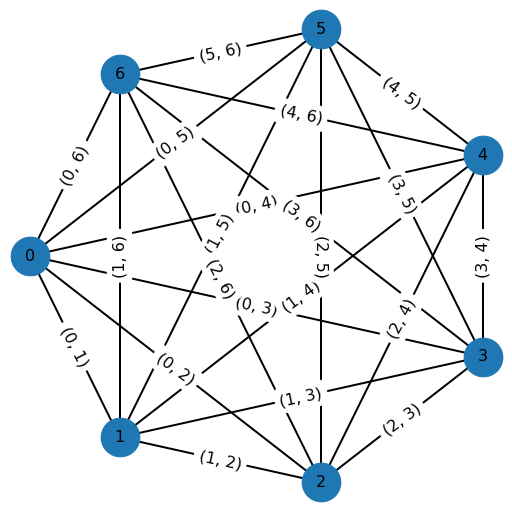

In [15]:
G = nx.complete_graph(7)
Hobj = annealing.IsingGraph({1:G, 2:G})
Hobj.drawNthOrderGraph(1)

In [21]:
len(G.edges)

21

In [36]:
G.degree[1]

6

In [70]:
def generate_graph(nedges, nnodes=7):
    if nedges < nnodes - 1:
        raise Exception("Cannot generate connected graph of %i nodes with %i edges" % (nnodes, nedges))
    G = nx.complete_graph(nnodes)
    my_edges = list(G.edges)
    my_nodes = list(G.nodes)
    remaining = len(G.edges)
    while remaining > nedges:

        # Pick an edge to remove at random
        sel_edge = my_edges[np.random.randint(remaining)]
        new_edges = [edge for edge in my_edges if edge != sel_edge]
        G = nx.Graph()
        G.add_nodes_from(my_nodes)
        G.add_edges_from(new_edges)

        # Check the order
        q1, q2 = sel_edge
        if not nx.is_connected(G):
            print("\\", end="")
        elif G.degree[q1] >= 1 and G.degree[q2] >= 1:
            my_edges = new_edges
            remaining -= 1
            print(".", end="")
        else:
            print("|", end="")
    G = nx.Graph()
    G.add_nodes_from(my_nodes)
    G.add_edges_from(my_edges)
    return G

def isomorphic(G_list, G):
    for lG in G_list:
        if nx.is_isomorphic(lG, G):
            return True
    return False

In [105]:
all_graphs = {}
edge_counts = np.arange(6, 18, 2)

for count in edge_counts:
    print("Doing %i edges" % count)
    graphs = []
    num = 10
    i = 0
    while i < num:
        G = generate_graph(count)
        if isomorphic(graphs, G):
            print("x", end='')
            continue
        graphs.append(G)
        i += 1
    all_graphs[count] = graphs
    print("")

Doing 6 edges
............\.\.\\\\\...............\.............\..\.x............\.................\...............\..............\.\\..............\.\\.x..............................x.............\..x..............\\\.x...............x..............\\............\...\\\\\\.x...............x..............\\\\\.x...............x..............\.x.........\.....\.x.............\.\\\\\\.x...........\....x...............x...............x..............\\\\.x..............\\.x.............\.\\\\\.x.............\\.\\\.x..........\...\\\.\.x............\.\..x.............\\\.\\.x...............x.............\..x..............\.x............\\..\.x..............\\\.x.........\..\....x..............\\\\.x...............x..........\.\....x.............\.\.x...........\...\.x.............\..x...............x.............\.\\\.x..............\\\\\.x..............\.x.............\.\\.x...............x..............\.x...............x............\...x...............x..............\\\\.x.............

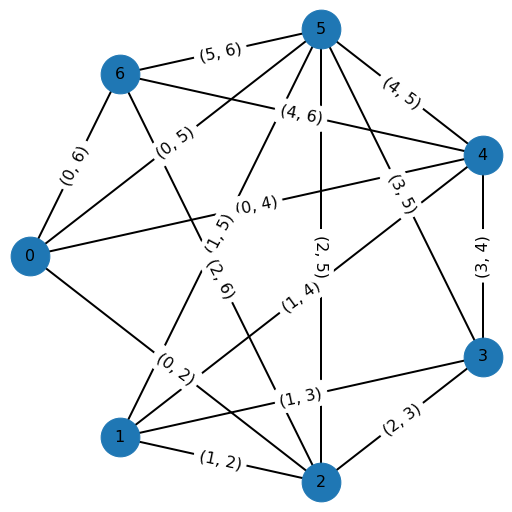

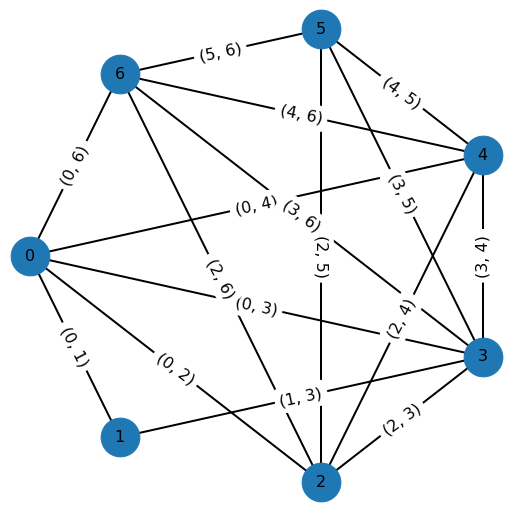

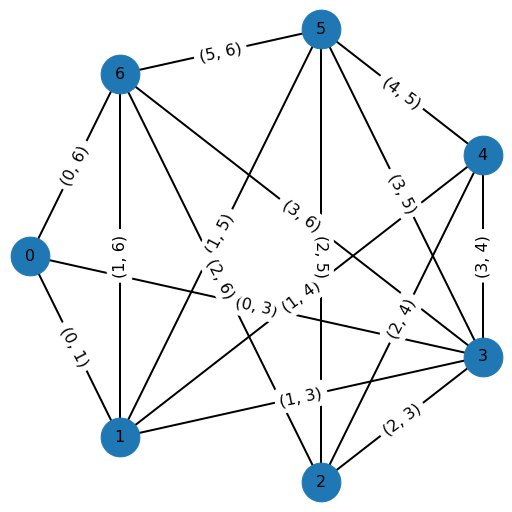

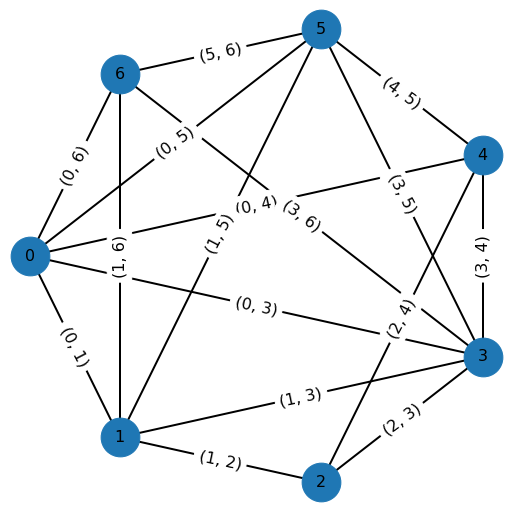

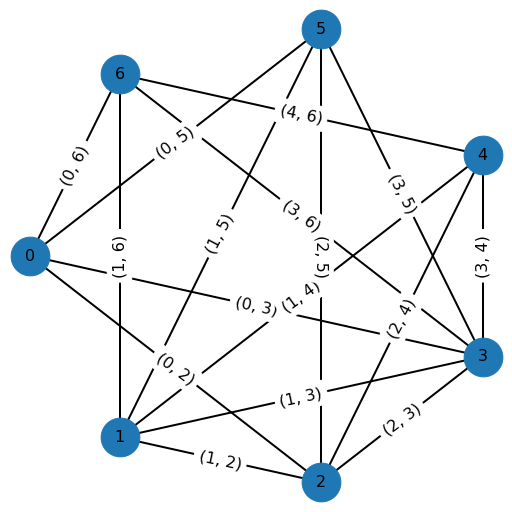

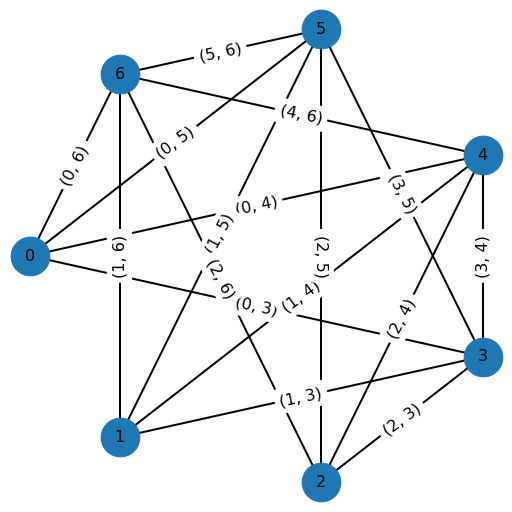

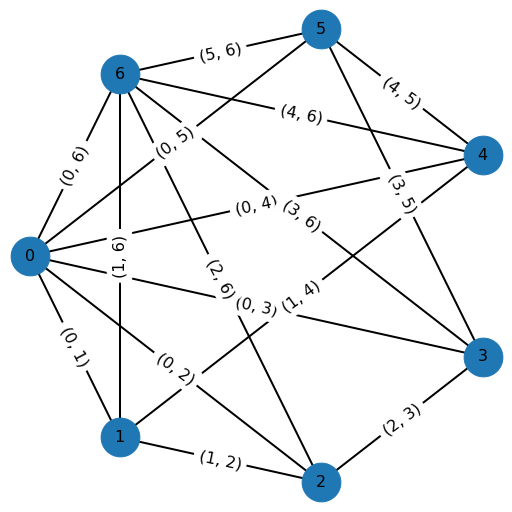

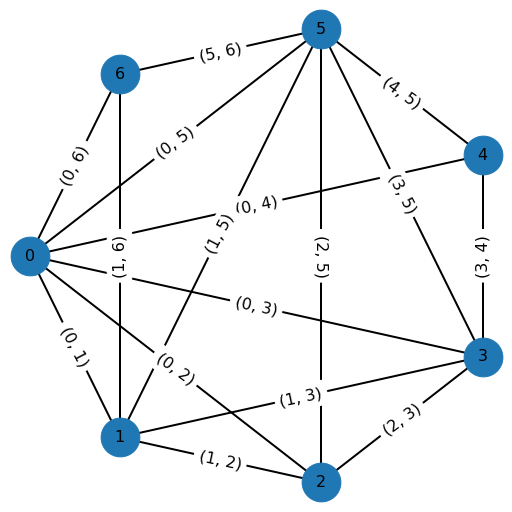

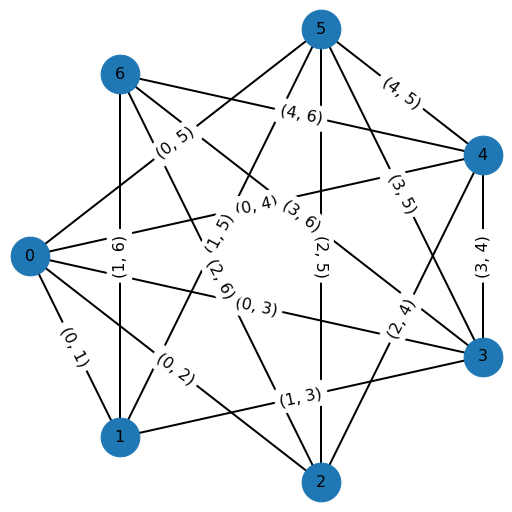

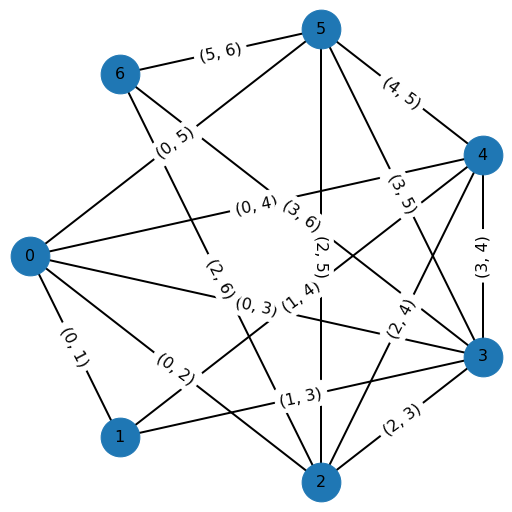

In [158]:
for G in all_graphs[16]:
    Hobj = annealing.IsingGraph({1:G, 2:G})
    Hobj.drawNthOrderGraph(1)
plt.savefig("random-instances-generation/example-graph-16.svg" % count, bbox_inches='tight')

In [124]:
R=1.0
n_qubits = 7
n_samples = 500
hard_thresh = 1.0
z_vals = None
J_vals = None
Hobj = None
npts = 10
sv = np.linspace(0,1,11)
debug=False
E=[]
V=[]

graph_binning = {k:{i:0 for i in range(10)} for k in all_graphs.keys()}
instances = {k:[] for k in all_graphs.keys()}
instance_data = {k:[] for k in all_graphs.keys()}
instance = {}
data = {}

tan = 100.0
npts = 10

for count, graphs in all_graphs.items():
    print("Doing edge count=%i" % count)
    n = 0
    
    aqa_probs = []
    dqa_probs_best = []
    dqa_probs = []
    dqa_all = []
    dqa_best_qubits = []

    er_aqa = []
    er_dqa = []
    er_dqa_all = []
    er_dqa_best = []

    dqa_indices = []
    dqa_wins = 0
    aqa_indices = []
    aqa_wins = 0
    tied_indices = []
    tied = 0

    gap_values = []
    hard_instances = []

    while n < n_samples:
        if not debug:
            print("%i " % n, end='')
        else:
            print("Sample %i" % n)
        
        # Select a graph a random
        graph_index = np.random.randint(len(graphs))
        graph_binning[count][graph_index] += 1
        G = graphs[graph_index]
        
        # Create annealing
        Hobj = annealing.IsingGraph({1:G, 2:G})

        # Generate random variables
        z_vals = np.random.normal(size=(len(Hobj.getNodes())))
        z_vals = z_vals/max(abs(z_vals))
        J_vals = [-0.5]*len(Hobj.getEdges())#np.random.normal(size=(len(Hobj.getEdges())))
        instance = {'graph':graph_index, 'coefficients':(z_vals, J_vals)}
        instances[count].append(instance)

        # Init the AQA instance
        if debug: print("  Initialising AQA")
        init_aqa(R)

        # Estimate hardness
        E = []
        V = []
        for s in sv:
            Es,Vs = Hobj.getHamiltonian(s).eigenstates()
            E.append(Es)
            V.append(Vs)
        E = np.array(E)
        Egmin = min(E[:, 1] - E[:, 0])
        if Egmin < hard_thresh:
            gap_values.append(Egmin)
            hard_instances.append(n)

        # Initial state
        Hs0 = Hobj.getHamiltonian(0.0)
        E, V = Hs0.eigenstates()
        V0 = V[0]

        # Ground state
        Hs1 = Hobj.getHamiltonian(1.0)
        Ep, Vp = Hs1.eigenstates()

        # Simulate for a given t_an
        tpts = np.linspace(0, tan, npts)
        ret = qt.sesolve(Hobj.getQobjEvo({'tan':tan}), V0, tpts)
        aqa_probs.append(abs(ret.states[-1].overlap(Vp[0]))**2)
        er_aqa.append(Hs1.overlap(ret.states[-1]) - Ep[0])

        if debug: print("  Initialising DQA")
        dqa_all = []
        er_dqa_all = []
        for qb in range(n_qubits):
            init_dqa(1.0, qb)

            # First normal linear schedule protocol
            # Initial state
            Hs0 = Hobj.getHamiltonian(0.0, {'spause':0.2})
            E, V = Hs0.eigenstates()
            V0 = V[0]

            # Ground state
            Hs1 = Hobj.getHamiltonian(1.0, {'spause':0.2})
            Ep, Vp = Hs1.eigenstates()

            # Simulate for a given t_an
            tpts = np.linspace(0, tan, npts)
            ret = qt.sesolve(Hobj.getQobjEvo({'tan':tan, 'spause':0.2}), V0, tpts)
            dqa_all.append(abs(ret.states[-1].overlap(Vp[0]))**2)
            er_dqa_all.append(Hs1.overlap(ret.states[-1]) - Ep[0])
        dqa_probs_best.append(max(dqa_all))
        er_dqa_best.append(min(er_dqa_all))
        dqa_best_qubits.append(nodes[np.argmin(er_dqa_all)])
        dqa_probs.append(dqa_all)
        er_dqa.append(er_dqa_all)

        # Save the indices in which DQA is better
        if np.allclose(er_dqa_best[n], er_aqa[n]):
            tied_indices.append(n)
        elif er_dqa_best[n] < er_aqa[n]:
            dqa_indices.append(n)
        else:
            aqa_indices.append(n)

        if debug: print("")
        n += 1
    
    instance_data[count] = {
        "aqa_probs": aqa_probs,
        "dqa_probs_best": dqa_probs_best,
        "dqa_probs": dqa_probs,
        "dqa_all": dqa_all,
        "dqa_best_qubits": dqa_best_qubits,
        "er_aqa": er_aqa,
        "er_dqa": er_dqa,
        "er_dqa_all": er_dqa_all,
        "er_dqa_best": er_dqa_best,
        "dqa_indices": dqa_indices,
        "dqa_wins": dqa_wins,
        "aqa_indices": aqa_indices,
        "aqa_wins": aqa_wins,
        "tied_indices": tied_indices,
        "tied": tied,
        "gap_values": gap_values,
        "hard_instances": hard_instances
    }
    
    print("")

Doing edge count=6
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272

In [125]:
graph_binning

{6: {0: 54, 1: 50, 2: 45, 3: 53, 4: 50, 5: 38, 6: 52, 7: 48, 8: 55, 9: 55},
 8: {0: 50, 1: 54, 2: 50, 3: 51, 4: 44, 5: 60, 6: 33, 7: 48, 8: 67, 9: 43},
 10: {0: 53, 1: 38, 2: 58, 3: 48, 4: 64, 5: 45, 6: 49, 7: 39, 8: 45, 9: 61},
 12: {0: 71, 1: 54, 2: 41, 3: 57, 4: 45, 5: 41, 6: 52, 7: 42, 8: 46, 9: 51},
 14: {0: 33, 1: 39, 2: 54, 3: 61, 4: 52, 5: 57, 6: 41, 7: 54, 8: 55, 9: 54},
 16: {0: 44, 1: 46, 2: 45, 3: 32, 4: 64, 5: 57, 6: 52, 7: 49, 8: 57, 9: 54}}

In [6]:
import pickle

def pickleWrite(obj, filename):
    # Open file for writing in binary
    fd = open(filename,"wb")
    
    # Pickle the object
    pickle.dump(obj,fd)
    
    # Write to file
    fd.close()
    
    return filename

def pickleRead(filename):
    # Read file in binary
    fd = open(filename,"rb")
    
    # Unpickle
    obj = pickle.load(fd)
    fd.close()
    
    return obj

In [528]:
# Save data
pickleWrite(
    [
        instance_data,
        all_graphs,
        instances,
        graph_binning
    ],
    "random-instances-generation/total-instance-data.bin"
)

'random-instances-generation/total-instance-data.bin'

In [7]:
instance_data, all_graphs, instances, graph_binning = pickleRead("random-instances-generation/total-instance-data.bin")

In [11]:
R=1.0
n_qubits = 7
n_samples = 500
hard_thresh = 1.0
z_vals = None
J_vals = None
Hobj = None
npts = 10
sv = np.linspace(0,1,11)
debug=False
E=[]
V=[]

6


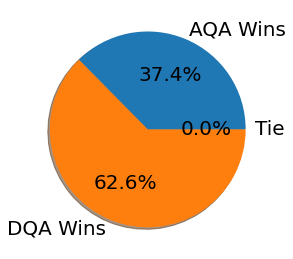

8


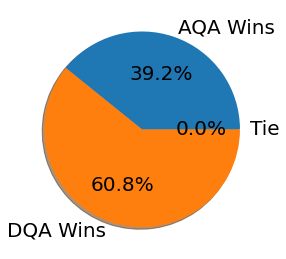

10


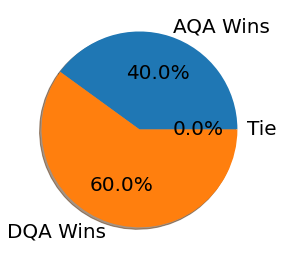

12


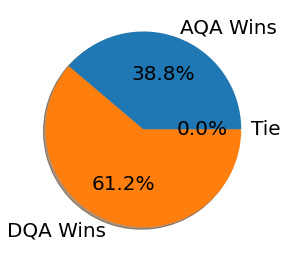

14


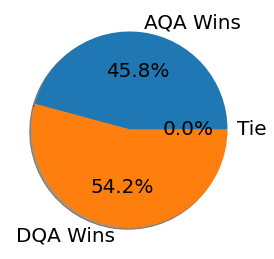

16


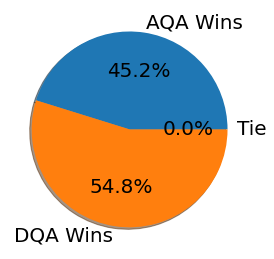

<Figure size 432x288 with 0 Axes>

In [12]:
for count, graphs in all_graphs.items():
    print(count)
    aqa_indices = instance_data[count]["aqa_indices"]
    dqa_indices = instance_data[count]["dqa_indices"]
    tied_indices = instance_data[count]["tied_indices"]
    labels = ['AQA Wins', 'DQA Wins', 'Tie']
    plt.pie([len(aqa_indices), len(dqa_indices), len(tied_indices)], labels=labels, shadow=True, autopct='%1.1f%%')
    plt.show()
    plt.savefig("random-instances-generation/total-wins-%i.svg" % count, bbox_inches='tight')

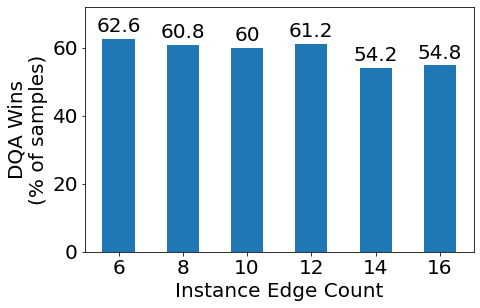

In [13]:
labels = [str(k) for k in all_graphs.keys()]
aqa_wins = [len(instance_data[count]["aqa_indices"])/n_samples*100.0 for count in all_graphs.keys()]
dqa_wins = [len(instance_data[count]["dqa_indices"])/n_samples*100.0 for count in all_graphs.keys()]
x = np.arange(len(labels))
w = 0.5
rects = plt.bar(x, dqa_wins, w, label="DQA Wins", color='C0')
plt.bar_label(rects, padding=3)
plt.xlabel('Instance Edge Count')
plt.ylabel('DQA Wins\n(% of samples)')
plt.xticks(x, labels)
plt.ylim(0, 72)
plt.savefig("random-instances-generation/dqa-win-rate.svg", bbox_inches='tight')
plt.show()

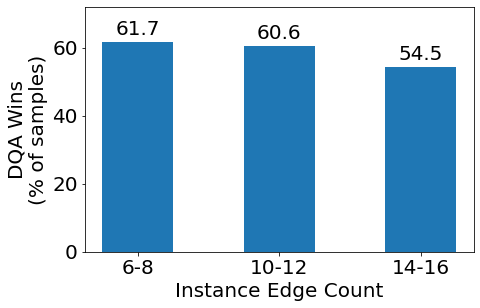

In [14]:
labels = ["6-8", "10-12", "14-16"]
aqa_wins = [len(instance_data[count]["aqa_indices"])/n_samples*100.0 for count in all_graphs.keys()]
dqa_wins = [len(instance_data[count]["dqa_indices"])/n_samples*100.0 for count in all_graphs.keys()]
dqa_wins_c = [(dqa_wins[0]+dqa_wins[1])/2, (dqa_wins[2]+dqa_wins[3])/2, (dqa_wins[4]+dqa_wins[5])/2]
x = np.arange(len(labels))
w = 0.5
rects = plt.bar(x, dqa_wins_c, w, label="DQA Wins", color='C0')
plt.bar_label(rects, padding=3)
plt.xlabel('Instance Edge Count')
plt.ylabel('DQA Wins\n(% of samples)')
plt.xticks(x, labels)
plt.ylim(0, 72)
plt.savefig("random-instances-generation/dqa-win-rate_c.svg", bbox_inches='tight')
plt.show()

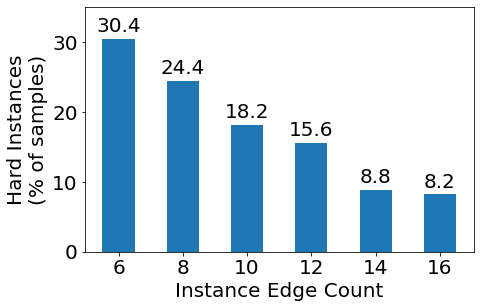

In [15]:
labels = [str(k) for k in all_graphs.keys()]
hard = [len(instance_data[count]["hard_instances"])/n_samples*100.0 for count in all_graphs.keys()]
x = np.arange(len(labels))
w = 0.5
rects = plt.bar(x, hard, w, label="Hard", color='C0')
plt.bar_label(rects, padding=3)
plt.xlabel('Instance Edge Count')
plt.ylabel('Hard Instances\n(% of samples)')
plt.xticks(x, labels)
plt.ylim(0, 35)
plt.savefig("random-instances-generation/hard-instances-tot.svg", bbox_inches='tight')
plt.show()

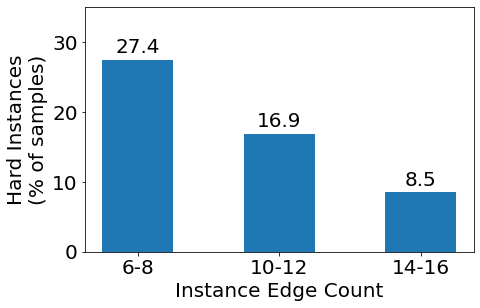

In [16]:
labels = ["6-8", "10-12", "14-16"]
hard = [len(instance_data[count]["hard_instances"])/n_samples*100.0 for count in all_graphs.keys()]
hard_c = [(hard[0]+hard[1])/2, (hard[2]+hard[3])/2, (hard[4]+hard[5])/2]
x = np.arange(len(labels))
w = 0.5
rects = plt.bar(x, hard_c, w, label="Hard", color='C0')
plt.bar_label(rects, padding=3)
plt.xlabel('Instance Edge Count')
plt.ylabel('Hard Instances\n(% of samples)')
plt.xticks(x, labels)
plt.ylim(0, 35)
plt.savefig("random-instances-generation/hard-instances-tot-c.svg", bbox_inches='tight')
plt.show()

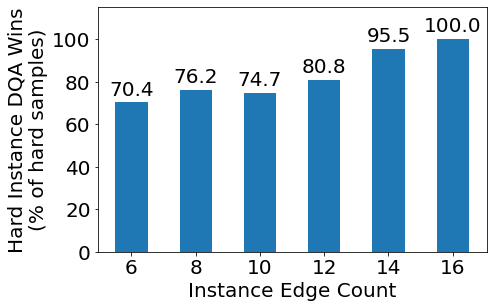

In [17]:
labels = [str(k) for k in all_graphs.keys()]
x = np.arange(len(labels))
w = 0.5
hard_wins = []
for count, graphs in all_graphs.items():
    aqa_wins = 0
    hard_instances = instance_data[count]["hard_instances"]
    er_aqa = instance_data[count]["er_aqa"]
    er_dqa_best = instance_data[count]["er_dqa_best"]
    for index in hard_instances:
        if er_aqa[index] < er_dqa_best[index]:
            aqa_wins += 1
    hard_wins.append((len(hard_instances) - aqa_wins)/len(hard_instances)*100.0)
rects = plt.bar(x, hard_wins, w, label="Hard", color='C0')
plt.bar_label(rects, padding=3, fmt='%.1f')
plt.xlabel('Instance Edge Count')
plt.ylabel('Hard Instance DQA Wins\n(% of hard samples)')
plt.xticks(x, labels)
plt.ylim(0, 115)
plt.savefig("random-instances-generation/hard-instances-dqa-wins.svg", bbox_inches='tight')
plt.show()

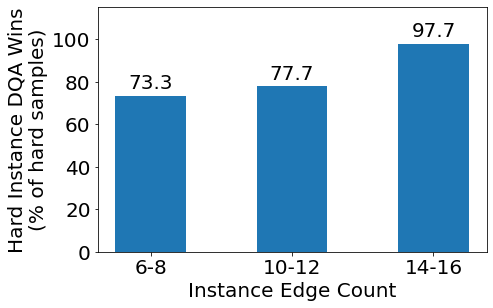

In [18]:
labels = ["6-8", "10-12", "14-16"]
x = np.arange(len(labels))
w = 0.5
hard_wins = []
for count, graphs in all_graphs.items():
    aqa_wins = 0
    hard_instances = instance_data[count]["hard_instances"]
    er_aqa = instance_data[count]["er_aqa"]
    er_dqa_best = instance_data[count]["er_dqa_best"]
    for index in hard_instances:
        if er_aqa[index] < er_dqa_best[index]:
            aqa_wins += 1
    hard_wins.append((len(hard_instances) - aqa_wins)/len(hard_instances)*100.0)
hard_wins_c = [(hard_wins[0]+hard_wins[1])/2, (hard_wins[2]+hard_wins[3])/2, (hard_wins[4]+hard_wins[5])/2]
rects = plt.bar(x, hard_wins_c, w, label="Hard", color='C0')
plt.bar_label(rects, padding=3, fmt='%.1f')
plt.xlabel('Instance Edge Count')
plt.ylabel('Hard Instance DQA Wins\n(% of hard samples)')
plt.xticks(x, labels)
plt.ylim(0, 115)
plt.savefig("random-instances-generation/hard-instances-dqa-wins-c.svg", bbox_inches='tight')
plt.show()

In [19]:
aqa_wins

0

6


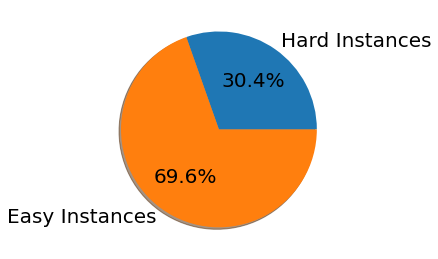

8


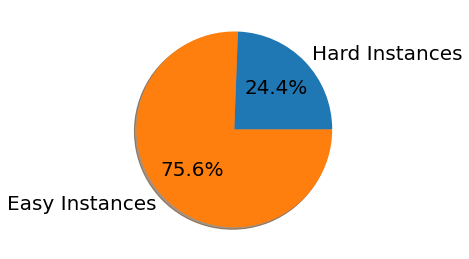

10


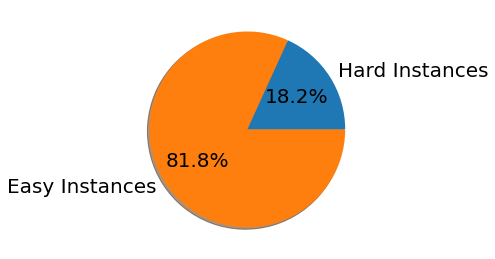

12


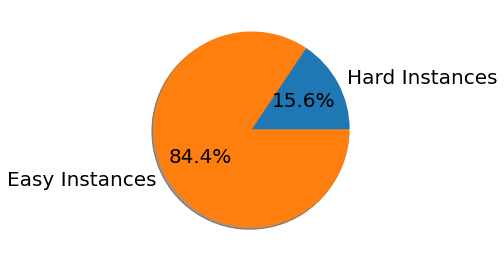

14


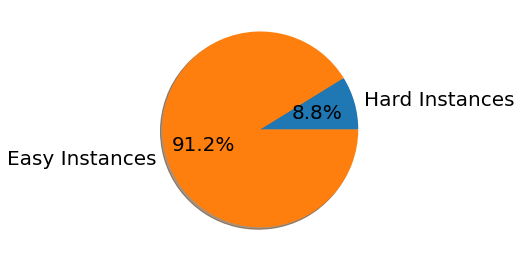

16


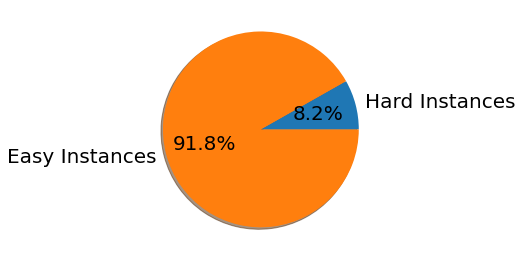

In [20]:
for count, graphs in all_graphs.items():
    print(count)
    hard_instances = instance_data[count]["hard_instances"]
    labels = ['Hard Instances', 'Easy Instances']
    plt.pie([len(hard_instances), n_samples - len(hard_instances)], labels=labels, shadow=True, autopct='%1.1f%%')
    plt.savefig("random-instances-generation/total-hard-%i.svg" % count, bbox_inches='tight')
    plt.show()

6


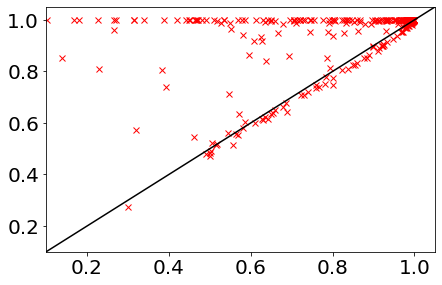

8


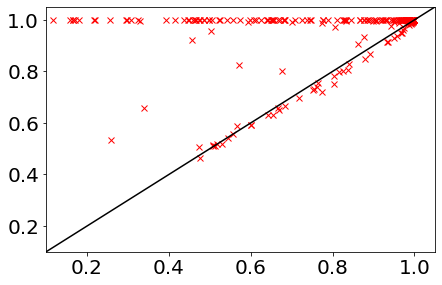

10


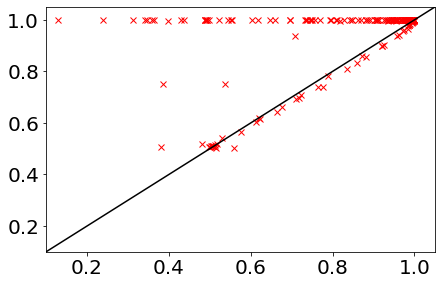

12


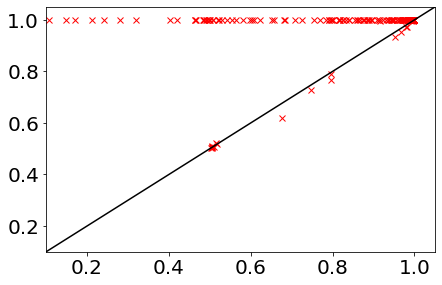

14


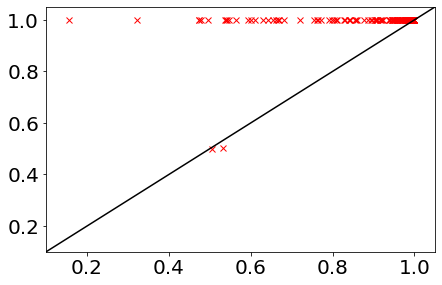

16


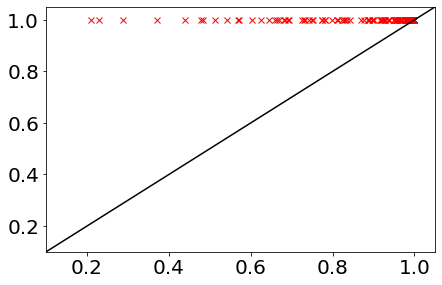

In [21]:
for count, graphs in all_graphs.items():
    print(count)
    aqa_probs = instance_data[count]["aqa_probs"]
    dqa_probs_best = instance_data[count]["dqa_probs_best"]
    plt.plot(np.array(aqa_probs), np.array(dqa_probs_best), 'rx')
    plt.plot([-1, 2], [-1, 2], 'k-')
    plt.xlim(1e-1, 1.05)
    plt.ylim(1e-1, 1.05)
    plt.show()

6


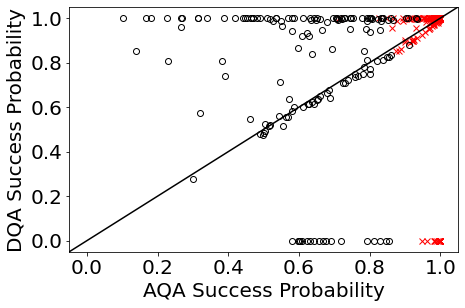

8


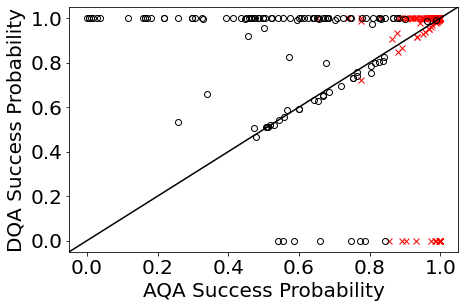

10


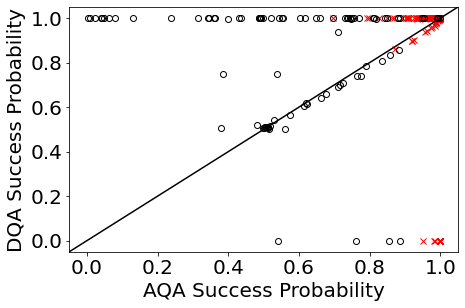

12


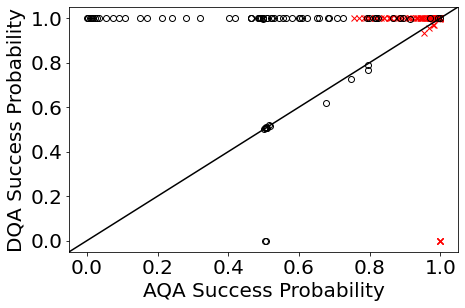

14


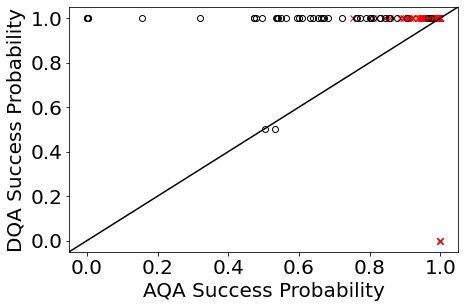

16


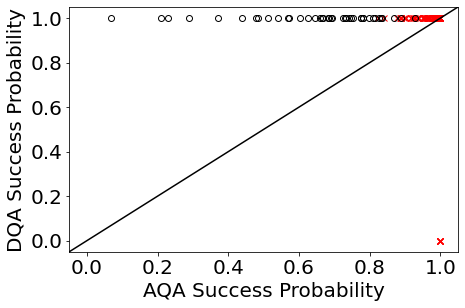

In [22]:
easy_aqa_c = []
easy_dqa_c = []
hard_aqa_c = []
hard_dqa_c = []
for count, graphs in all_graphs.items():
    print(count)
    aqa_probs = instance_data[count]["aqa_probs"]
    dqa_probs_best = instance_data[count]["dqa_probs_best"]
    hard_instances = instance_data[count]["hard_instances"]
    hard_aqa_probs = []
    hard_dqa_probs = []
    aqa_wins = 0
    for index in hard_instances:
        hard_aqa_probs.append(aqa_probs[index])
        hard_dqa_probs.append(dqa_probs_best[index])
    aqa_probs_n = np.delete(aqa_probs, hard_instances)
    dqa_probs_best_n = np.delete(dqa_probs_best, hard_instances)
    
    plt.plot(np.array(aqa_probs_n), np.array(dqa_probs_best_n), 'rx')
    plt.plot(np.array(hard_aqa_probs), np.array(hard_dqa_probs), 'ko', fillstyle='none')
    plt.plot([-1, 2], [-1, 2], 'k-')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("AQA Success Probability")
    plt.ylabel("DQA Success Probability")
    plt.savefig("random-instances-generation/success-comparison-%i.svg" % count, bbox_inches='tight')
    plt.show()
    easy_aqa_c.append(np.array(aqa_probs_n))
    easy_dqa_c.append(np.array(dqa_probs_best_n))
    hard_aqa_c.append(np.array(hard_aqa_probs))
    hard_dqa_c.append(np.array(hard_dqa_probs))

In [23]:
easy_aqa_1 = np.append(easy_aqa_c[0], easy_aqa_c[1])
easy_aqa_2 = np.append(easy_aqa_c[2], easy_aqa_c[3])
easy_aqa_3 = np.append(easy_aqa_c[4], easy_aqa_c[5])
easy_dqa_1 = np.append(easy_dqa_c[0], easy_dqa_c[1])
easy_dqa_2 = np.append(easy_dqa_c[2], easy_dqa_c[3])
easy_dqa_3 = np.append(easy_dqa_c[4], easy_dqa_c[5])
hard_aqa_1 = np.append(hard_aqa_c[0], hard_aqa_c[1])
hard_aqa_2 = np.append(hard_aqa_c[2], hard_aqa_c[3])
hard_aqa_3 = np.append(hard_aqa_c[4], hard_aqa_c[5])
hard_dqa_1 = np.append(hard_dqa_c[0], hard_dqa_c[1])
hard_dqa_2 = np.append(hard_dqa_c[2], hard_dqa_c[3])
hard_dqa_3 = np.append(hard_dqa_c[4], hard_dqa_c[5])

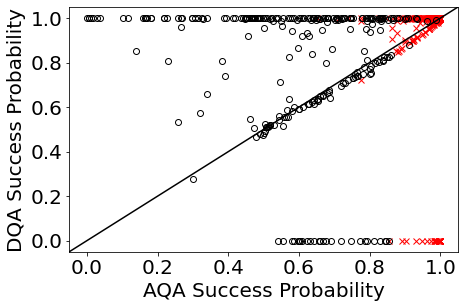

In [24]:
plt.plot(easy_aqa_1, easy_dqa_1, 'rx')
plt.plot(hard_aqa_1, hard_dqa_1, 'ko', fillstyle='none')
plt.plot([-1, 2], [-1, 2], 'k-')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("AQA Success Probability")
plt.ylabel("DQA Success Probability")
plt.savefig("random-instances-generation/success-comparison-6-8.svg", bbox_inches='tight')
plt.show()

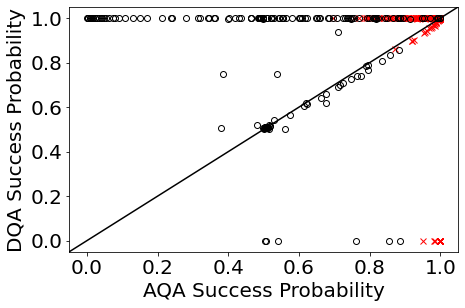

In [25]:
plt.plot(easy_aqa_2, easy_dqa_2, 'rx')
plt.plot(hard_aqa_2, hard_dqa_2, 'ko', fillstyle='none')
plt.plot([-1, 2], [-1, 2], 'k-')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("AQA Success Probability")
plt.ylabel("DQA Success Probability")
plt.savefig("random-instances-generation/success-comparison-10-12.svg", bbox_inches='tight')
plt.show()

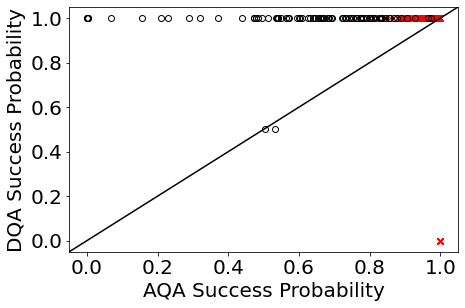

In [26]:
plt.plot(easy_aqa_3, easy_dqa_3, 'rx')
plt.plot(hard_aqa_3, hard_dqa_3, 'ko', fillstyle='none')
plt.plot([-1, 2], [-1, 2], 'k-')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("AQA Success Probability")
plt.ylabel("DQA Success Probability")
plt.savefig("random-instances-generation/success-comparison-14-16.svg", bbox_inches='tight')
plt.show()

6


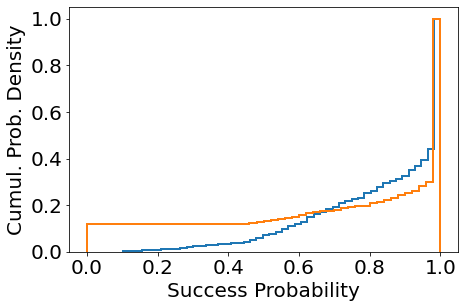

8


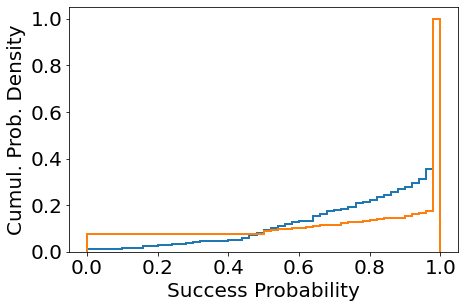

10


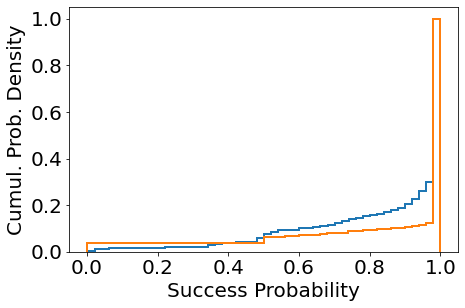

12


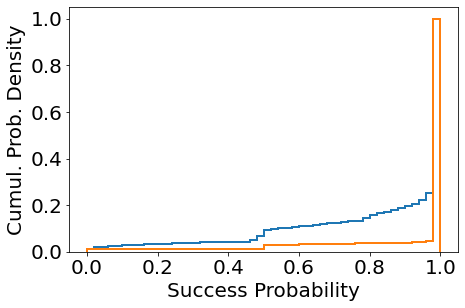

14


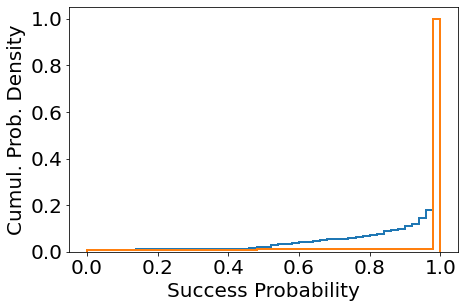

16


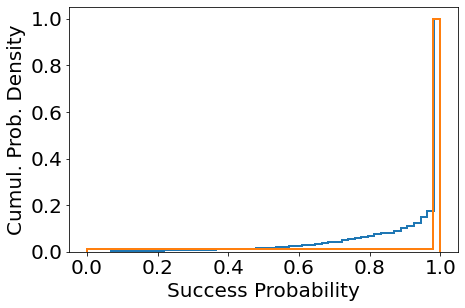

In [27]:
for count, graphs in all_graphs.items():
    print(count)
    aqa_probs = instance_data[count]["aqa_probs"]
    dqa_probs_best = instance_data[count]["dqa_probs_best"]
    hard_instances = instance_data[count]["hard_instances"]
    hard_aqa_probs = []
    hard_dqa_probs = []
    aqa_wins = 0
    for index in hard_instances:
        hard_aqa_probs.append(aqa_probs[index])
        hard_dqa_probs.append(dqa_probs_best[index])
    aqa_probs_n = np.delete(aqa_probs, hard_instances)
    dqa_probs_best_n = np.delete(dqa_probs_best, hard_instances)
    
    n_bins = 50
    bins, a, a = plt.hist(
        np.array(aqa_probs),
        bins=n_bins,
        density=True,
        histtype='step',
        cumulative=True,
        label="AQA",
        linewidth=2
    )
    bins, a, a = plt.hist(
        np.array(dqa_probs_best),
        bins=n_bins,
        density=True,
        histtype='step',
        cumulative=True,
        label="DQA",
        linewidth=2
    )
    plt.xlabel("Success Probability")
    plt.ylabel("Cumul. Prob. Density")
    plt.savefig("random-instances-generation/all-cumul-comparison-%i.svg" % count, bbox_inches='tight')
    plt.show()
    

6


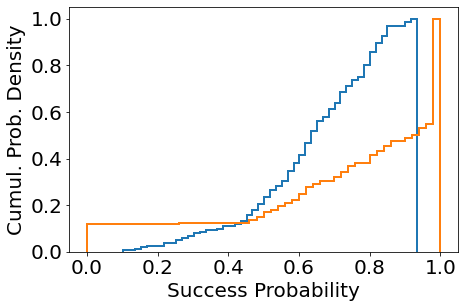

8


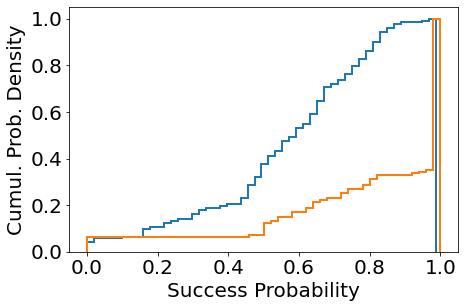

10


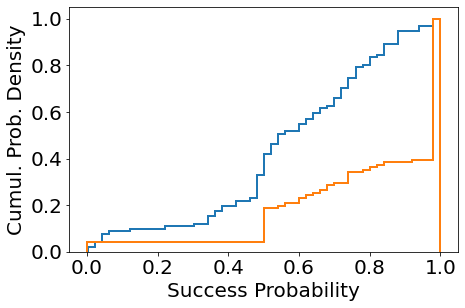

12


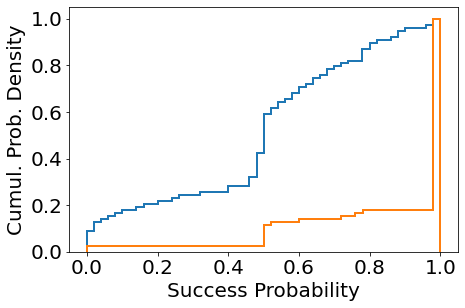

14


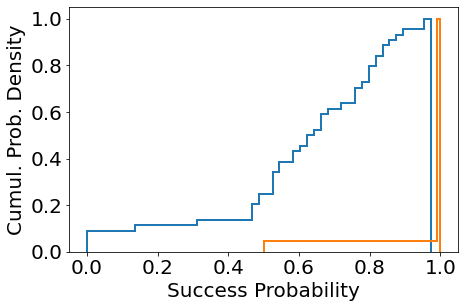

16


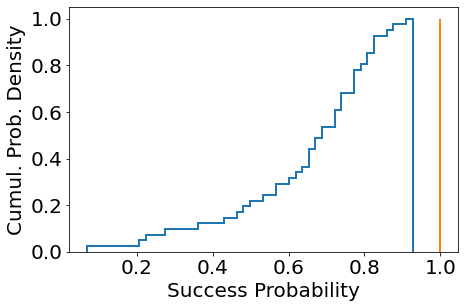

In [28]:
hard_aqa_probs_c = []
hard_dqa_probs_c = []
for count, graphs in all_graphs.items():
    print(count)
    aqa_probs = instance_data[count]["aqa_probs"]
    dqa_probs_best = instance_data[count]["dqa_probs_best"]
    hard_instances = instance_data[count]["hard_instances"]
    hard_aqa_probs = []
    hard_dqa_probs = []
    aqa_wins = 0
    for index in hard_instances:
        hard_aqa_probs.append(aqa_probs[index])
        hard_dqa_probs.append(dqa_probs_best[index])
    aqa_probs_n = np.delete(aqa_probs, hard_instances)
    dqa_probs_best_n = np.delete(dqa_probs_best, hard_instances)
    
    n_bins = 50
    bins, a, a = plt.hist(
        np.array(hard_aqa_probs),
        bins=n_bins,
        density=True,
        histtype='step',
        cumulative=True,
        label="AQA",
        linewidth=2
    )
    bins, a, a = plt.hist(
        np.array(hard_dqa_probs),
        bins=n_bins,
        density=True,
        histtype='step',
        cumulative=True,
        label="DQA",
        linewidth=2
    )
    plt.xlabel("Success Probability")
    plt.ylabel("Cumul. Prob. Density")
    plt.savefig("random-instances-generation/hard-cumul-comparison-%i.svg" % count, bbox_inches='tight')
    plt.show()
    hard_aqa_probs_c.append(np.array(hard_aqa_probs))
    hard_dqa_probs_c.append(np.array(hard_dqa_probs))

In [29]:
hard_aqa_probs_1 = np.append(hard_aqa_probs_c[0], hard_aqa_probs_c[1])
hard_aqa_probs_2 = np.append(hard_aqa_probs_c[2], hard_aqa_probs_c[3])
hard_aqa_probs_3 = np.append(hard_aqa_probs_c[4], hard_aqa_probs_c[5])
hard_dqa_probs_1 = np.append(hard_dqa_probs_c[0], hard_dqa_probs_c[1])
hard_dqa_probs_2 = np.append(hard_dqa_probs_c[2], hard_dqa_probs_c[3])
hard_dqa_probs_3 = np.append(hard_dqa_probs_c[4], hard_dqa_probs_c[5])

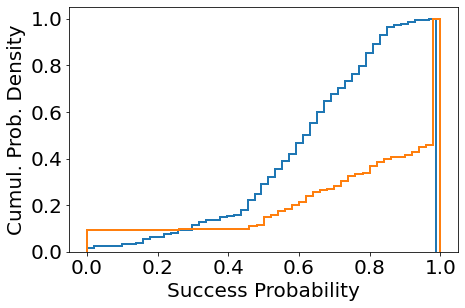

In [30]:
n_bins = 50
bins, a, a = plt.hist(
    np.array(hard_aqa_probs_1),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="AQA",
    linewidth=2
)
bins, a, a = plt.hist(
    np.array(hard_dqa_probs_1),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="DQA",
    linewidth=2
)
plt.xlabel("Success Probability")
plt.ylabel("Cumul. Prob. Density")
plt.savefig("random-instances-generation/hard-cumul-comparison-6-8.svg" % count, bbox_inches='tight')
plt.show()

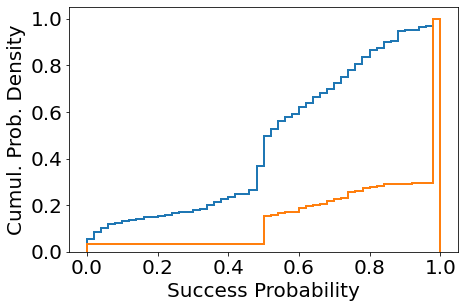

In [31]:
n_bins = 50
bins, a, a = plt.hist(
    np.array(hard_aqa_probs_2),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="AQA",
    linewidth=2
)
bins, a, a = plt.hist(
    np.array(hard_dqa_probs_2),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="DQA",
    linewidth=2
)
plt.xlabel("Success Probability")
plt.ylabel("Cumul. Prob. Density")
plt.savefig("random-instances-generation/hard-cumul-comparison-10-12.svg" % count, bbox_inches='tight')
plt.show()

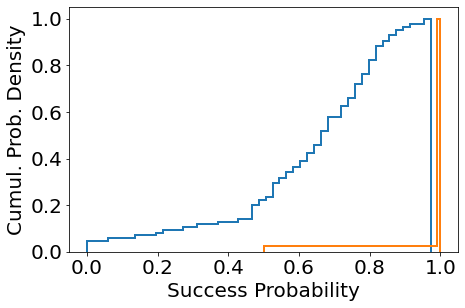

In [32]:
n_bins = 50
bins, a, a = plt.hist(
    np.array(hard_aqa_probs_3),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="AQA",
    linewidth=2
)
bins, a, a = plt.hist(
    np.array(hard_dqa_probs_3),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="DQA",
    linewidth=2
)
plt.xlabel("Success Probability")
plt.ylabel("Cumul. Prob. Density")
plt.savefig("random-instances-generation/hard-cumul-comparison-14-16.svg" % count, bbox_inches='tight')
plt.show()

6


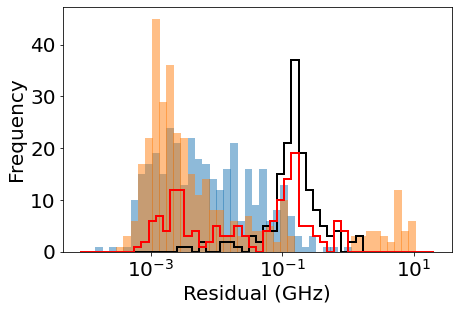

8


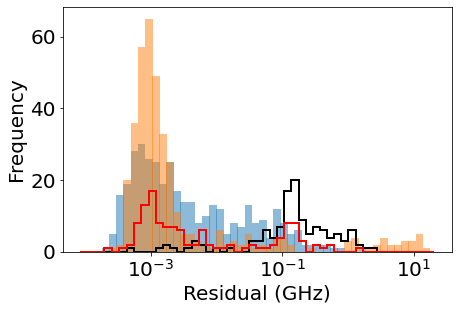

10


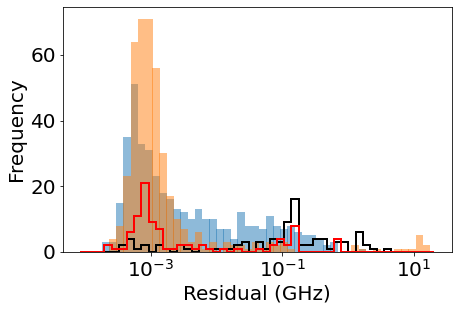

12


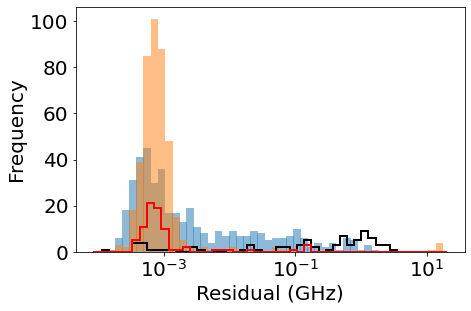

14


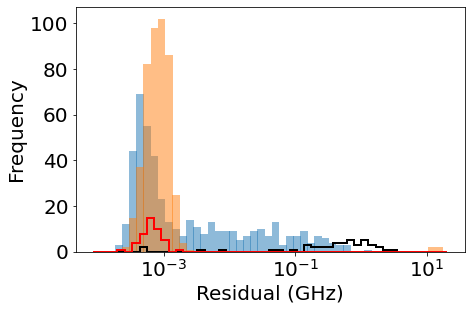

16


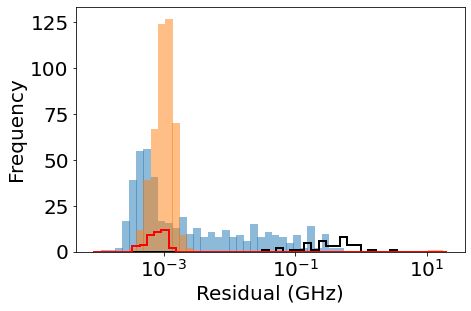

In [33]:
er_aqa_easy_c = []
er_dqa_easy_c = []
er_aqa_hard_c = []
er_dqa_hard_c = []
for count, graphs in all_graphs.items():
    print(count)
    er_aqa = instance_data[count]["er_aqa"]
    er_dqa_best = instance_data[count]["er_dqa_best"]
    hard_instances = instance_data[count]["hard_instances"]
    er_aqa_hard = [er_aqa[i] for i in hard_instances]
    er_dqa_hard = [er_dqa_best[i] for i in hard_instances]
    er_aqa_hard_c.append(er_aqa_hard)
    er_dqa_hard_c.append(er_dqa_hard)
    er_aqa_n = np.delete(er_aqa, hard_instances)
    er_dqa_n = np.delete(er_dqa_best, hard_instances)
    er_aqa_easy_c.append(er_aqa_n)
    er_dqa_easy_c.append(er_dqa_n)
    
    n_bins=50
    bins, a, a = plt.hist(
        np.array(er_aqa_n),
        bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
        rwidth=0.95,
        align='left',
        linewidth=2,
        alpha=0.5
    )
    bins, a, a = plt.hist(
        np.array(er_dqa_n),
        bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
        rwidth=0.95,
        align='left',
        linewidth=2,
        alpha=0.5
    )
    bins, a, a = plt.hist(
        np.array(er_aqa_hard),
        bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
        rwidth=0.95,
        align='left',
        linewidth=2,
        histtype='step',
        edgecolor='k'
    )
    bins, a, a = plt.hist(
        np.array(er_dqa_hard),
        bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
        rwidth=0.95,
        align='left',
        linewidth=2,
        histtype='step',
        edgecolor='r'
    )
    plt.xlabel("Residual (GHz)")
    plt.ylabel("Frequency")
    plt.xscale('log')
    plt.show()

In [34]:
hard_aqa_er_1 = np.append(er_aqa_hard_c[0], er_aqa_hard_c[1])
hard_aqa_er_2 = np.append(er_aqa_hard_c[2], er_aqa_hard_c[3])
hard_aqa_er_3 = np.append(er_aqa_hard_c[4], er_aqa_hard_c[5])
hard_dqa_er_1 = np.append(er_dqa_hard_c[0], er_dqa_hard_c[1])
hard_dqa_er_2 = np.append(er_dqa_hard_c[2], er_dqa_hard_c[3])
hard_dqa_er_3 = np.append(er_dqa_hard_c[4], er_dqa_hard_c[5])
easy_aqa_er_1 = np.append(er_aqa_easy_c[0], er_aqa_easy_c[1])
easy_aqa_er_2 = np.append(er_aqa_easy_c[2], er_aqa_easy_c[3])
easy_aqa_er_3 = np.append(er_aqa_easy_c[4], er_aqa_easy_c[5])
easy_dqa_er_1 = np.append(er_dqa_easy_c[0], er_dqa_easy_c[1])
easy_dqa_er_2 = np.append(er_dqa_easy_c[2], er_dqa_easy_c[3])
easy_dqa_er_3 = np.append(er_dqa_easy_c[4], er_dqa_easy_c[5])

### 6-8

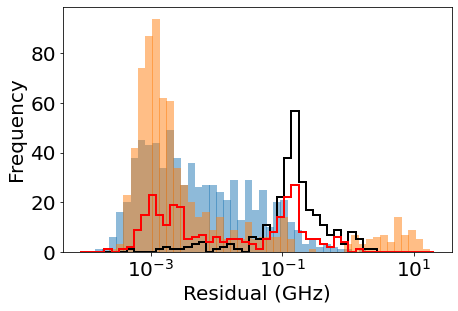

In [85]:
n_bins=50
bins1, a1, a = plt.hist(
    np.array(easy_aqa_er_1),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.5
)
bins2, a2, a = plt.hist(
    np.array(easy_dqa_er_1),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.5
)
bins3, a3, a = plt.hist(
    np.array(hard_aqa_er_1),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='k'
)
bins4, a4, a = plt.hist(
    np.array(hard_dqa_er_1),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='r'
)
plt.xlabel("Residual (GHz)")
plt.ylabel("Frequency")
plt.xscale('log')
plt.savefig("random-instances-generation/er-comparison-6-8.svg" % count, bbox_inches='tight')
plt.show()

In [86]:
w1 = max(max(bins1), max(bins2))
w2 = max(max(bins3), max(bins4))
#w1 = [w1]*(n_bins-1)

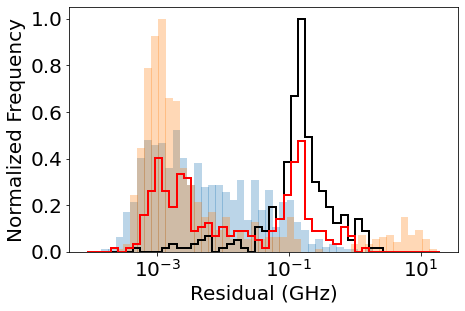

In [89]:
n_bins=50
bins, a, a = plt.hist(
    a1[:-1],
    bins=a1,
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.3,
    weights=bins1/w1
)
bins, a, a = plt.hist(
    a2[:-1],
    bins=a2,
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.3,
    weights=bins2/w1
)
bins, a, a = plt.hist(
    a3[:-1],
    bins=a3,
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='k',
    weights=bins3/w2
)
bins, a, a = plt.hist(
    a4[:-1],
    bins=a4,
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='r',
    weights=bins4/w2
)
plt.xlabel("Residual (GHz)")
plt.ylabel("Normalized Frequency")
plt.xscale('log')
plt.savefig("random-instances-generation/er-comparison-6-8.svg" % count, bbox_inches='tight')
plt.show()

### 10-12

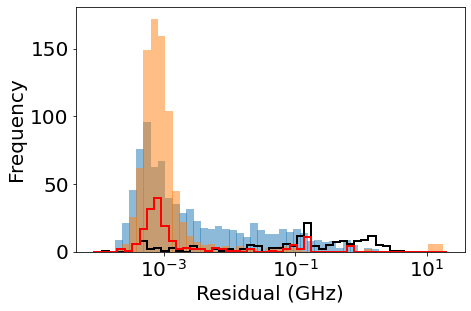

In [93]:
n_bins=50
bins1, a1, a = plt.hist(
    np.array(easy_aqa_er_2),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.5
)
bins2, a2, a = plt.hist(
    np.array(easy_dqa_er_2),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.5
)
bins3, a3, a = plt.hist(
    np.array(hard_aqa_er_2),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='k'
)
bins4, a4, a = plt.hist(
    np.array(hard_dqa_er_2),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='r'
)
plt.xlabel("Residual (GHz)")
plt.ylabel("Frequency")
plt.xscale('log')
plt.savefig("random-instances-generation/er-comparison-10-12.svg" % count, bbox_inches='tight')
plt.show()

In [94]:
w1 = max(max(bins1), max(bins2))
w2 = max(max(bins3), max(bins4))
#w1 = [w1]*(n_bins-1)

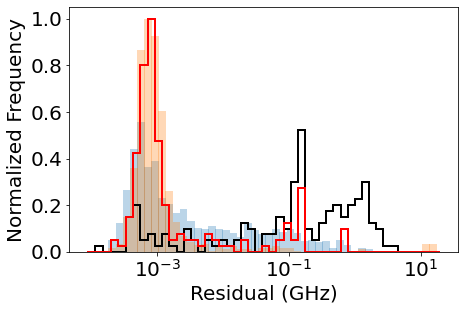

In [95]:
n_bins=50
bins, a, a = plt.hist(
    a1[:-1],
    bins=a1,
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.3,
    weights=bins1/w1
)
bins, a, a = plt.hist(
    a2[:-1],
    bins=a2,
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.3,
    weights=bins2/w1
)
bins, a, a = plt.hist(
    a3[:-1],
    bins=a3,
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='k',
    weights=bins3/w2
)
bins, a, a = plt.hist(
    a4[:-1],
    bins=a4,
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='r',
    weights=bins4/w2
)
plt.xlabel("Residual (GHz)")
plt.ylabel("Normalized Frequency")
plt.xscale('log')
plt.savefig("random-instances-generation/er-comparison-10-12.svg" % count, bbox_inches='tight')
plt.show()

### 14-16

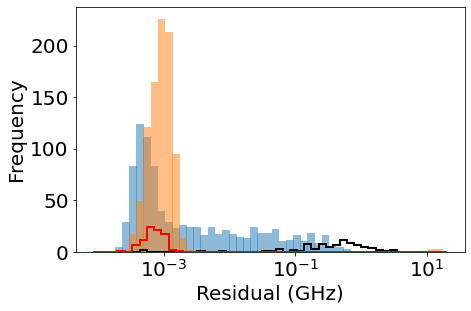

In [96]:
n_bins=50
bins1, a1, a = plt.hist(
    np.array(easy_aqa_er_3),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.5
)
bins2, a2, a = plt.hist(
    np.array(easy_dqa_er_3),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.5
)
bins3, a3, a = plt.hist(
    np.array(hard_aqa_er_3),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='k'
)
bins4, a4, a = plt.hist(
    np.array(hard_dqa_er_3),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='r'
)
plt.xlabel("Residual (GHz)")
plt.ylabel("Frequency")
plt.xscale('log')
plt.savefig("random-instances-generation/er-comparison-14-16.svg" % count, bbox_inches='tight')
plt.show()

In [97]:
w1 = max(max(bins1), max(bins2))
w2 = max(max(bins3), max(bins4))
#w1 = [w1]*(n_bins-1)

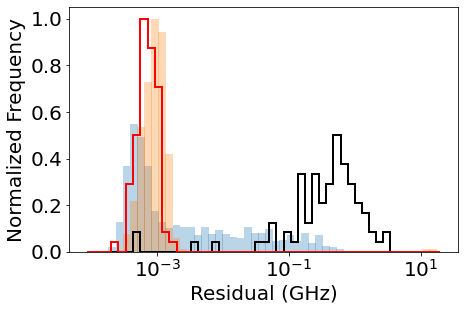

In [99]:
n_bins=50
bins, a, a = plt.hist(
    a1[:-1],
    bins=a1,
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.3,
    weights=bins1/w1
)
bins, a, a = plt.hist(
    a2[:-1],
    bins=a2,
    rwidth=0.95,
    align='left',
    linewidth=2,
    alpha=0.3,
    weights=bins2/w1
)
bins, a, a = plt.hist(
    a3[:-1],
    bins=a3,
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='k',
    weights=bins3/w2
)
bins, a, a = plt.hist(
    a4[:-1],
    bins=a4,
    rwidth=0.95,
    align='left',
    linewidth=2,
    histtype='step',
    edgecolor='r',
    weights=bins4/w2
)
plt.xlabel("Residual (GHz)")
plt.ylabel("Normalized Frequency")
plt.xscale('log')
plt.savefig("random-instances-generation/er-comparison-14-16.svg" % count, bbox_inches='tight')
plt.show()

6


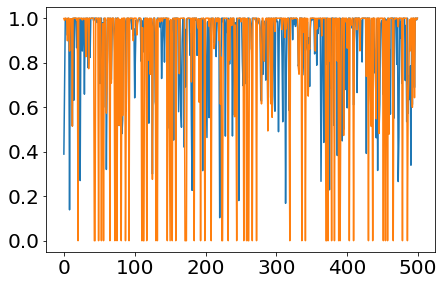

8


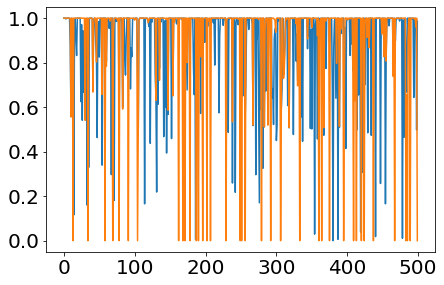

10


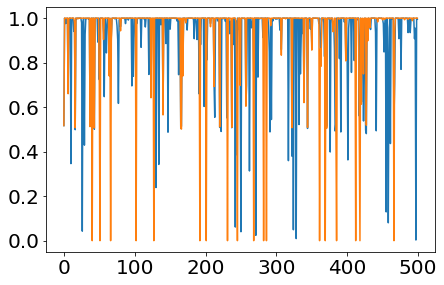

12


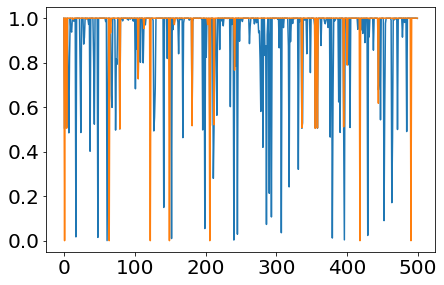

14


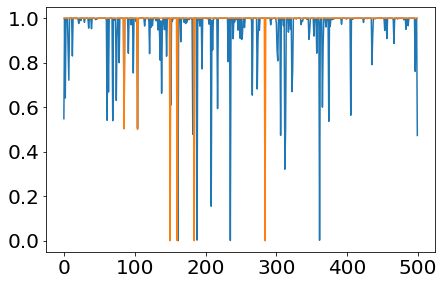

16


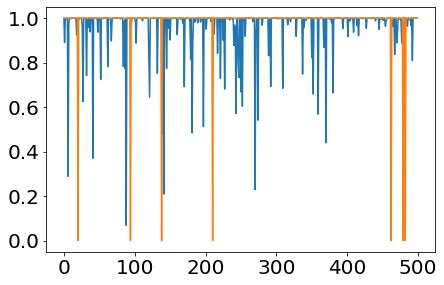

In [236]:
for count, graphs in all_graphs.items():
    print(count)
    aqa_probs = instance_data[count]["aqa_probs"]
    dqa_probs_best = instance_data[count]["dqa_probs_best"]
    hard_instances = instance_data[count]["hard_instances"]
    plt.plot(range(n_samples), aqa_probs)
    plt.plot(range(n_samples), dqa_probs_best)
    plt.show()

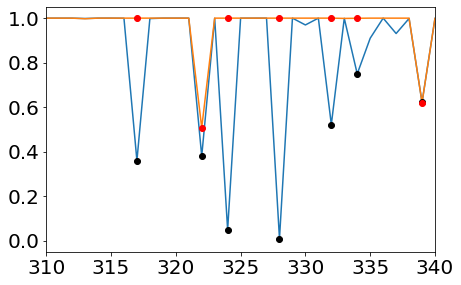

In [502]:
count = 10
aqa_probs = instance_data[count]["aqa_probs"]
dqa_probs_best = instance_data[count]["dqa_probs_best"]
hard_instances = instance_data[count]["hard_instances"]
plt.plot(range(n_samples), aqa_probs)
plt.plot(range(n_samples), dqa_probs_best)
plt.plot(hard_instances, [aqa_probs[i] for i in hard_instances], 'ko')
plt.plot(hard_instances, [dqa_probs_best[i] for i in hard_instances], 'ro')
plt.xlim(310, 340)
plt.show()

### Instance where DQA wins massively

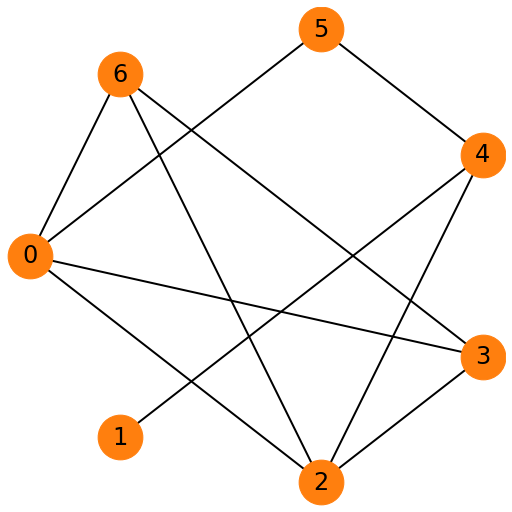

In [75]:
index = 328
count = 10
instances[count][index]
G = all_graphs[count][instances[count][index]['graph']]
z_vals = instances[count][index]['coefficients'][0]
J_vals = instances[count][index]['coefficients'][1]
Hobj = annealing.IsingGraph({1:G, 2:G})
#Hobj.drawNthOrderGraph(1)

fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(7,7))
        
# Get layout first as it is randomly generated
#L = nx.spring_layout(self.graph_family[n])
#L = nx.planar_layout(self.graph_family[n])
#L = nx.kamada_kawai_layout(self.graph_family[n])
L = nx.shell_layout(Hobj.graph_family[1])

Hobj._update_node_labels()
nx.draw(
    Hobj.graph_family[1],
    pos=L,
    with_labels=True,
    node_color="C1",
    node_size=2000,
    width=2,
    labels=Hobj.node_labels,
    font_weight="normal",
    font_size=24,
    ax=ax
)
plt.savefig("random-instance-graph.png", bbox_inches='tight')
plt.show()

init_aqa(1)

In [76]:
npts = 101
n = 7
sv = np.linspace(0, 1, npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

# individual components of magnetization for each qubit
msz = np.zeros((n, npts))
msx = np.zeros((n, npts))
for j in range(n):
    sz = Hobj.getOperator(j, 'hz')
    sx = Hobj.getOperator(j, 'hx')
    for i,s in enumerate(sv):
        msz[j,i] = sz.overlap(V[i][0])
        msx[j,i] = sx.overlap(V[i][0])


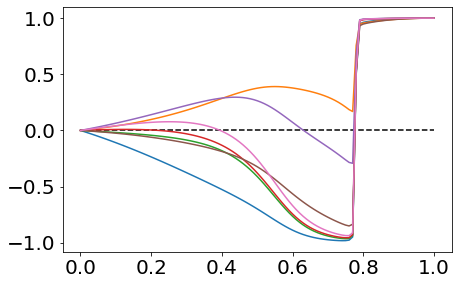

In [77]:
plt.plot(sv, E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv, msz[i])
plt.savefig("random-instance-magz.png", bbox_inches='tight')
#plt.xlabel("$s$")
#plt.ylabel("$\\langle \\sigma_z \\rangle$")
#plt.title("Qubit Z Magnetization")

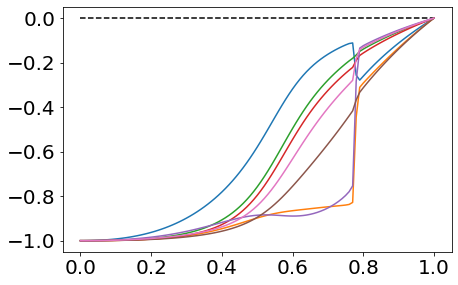

In [78]:
plt.plot(sv, E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv, msx[i])
plt.savefig("random-instance-magx.png", bbox_inches='tight')
#plt.xlabel("$s$")
#plt.ylabel("$\\langle \\sigma_z \\rangle$")
#plt.title("Qubit Z Magnetization")

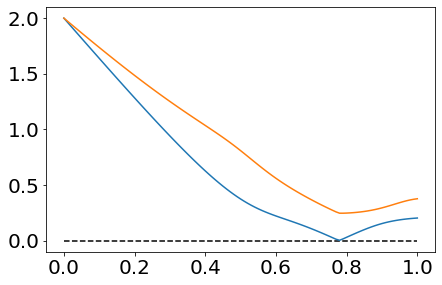

In [79]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))
plt.savefig("random-instance-spectrum.png", bbox_inches='tight')

In [80]:
dqa_probs = instance_data[count]["dqa_probs"]
dqa_probs[index]

[0.9999481530086005,
 0.0,
 0.9999295496540526,
 0.0,
 0.0,
 0.9941594385855796,
 0.0]

In [81]:
dqa_tts = 100.0*np.log(0.01)/np.log(1-dqa_probs[index][0])
dqa_tts

46.67143480735967

In [82]:
aqa_probs = instance_data[count]["aqa_probs"]
aqa_probs[index]

0.009345828702992408

In [83]:
aqa_tts = 100.0*np.log(0.01)/np.log(1-aqa_probs[index])
aqa_tts

49044.521235482

In [84]:
aqa_tts/dqa_tts

1050.8466568023343

In [85]:
msx_aqa = msx

In [86]:
init_dqa(1, 0)

In [87]:
npts = 101
n = 7
p = {'spause':0.2}
sv = np.linspace(0, 1, npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s, p).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

# individual components of magnetization for each qubit
msz = np.zeros((n, npts))
msx = np.zeros((n, npts))
for j in range(n):
    sz = Hobj.getOperator(j, 'hz')
    sx = Hobj.getOperator(j, 'hx')
    for i,s in enumerate(sv):
        msz[j,i] = sz.overlap(V[i][0])
        msx[j,i] = sx.overlap(V[i][0])

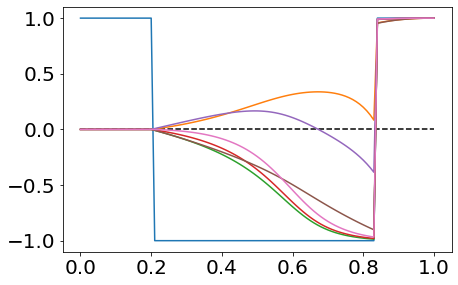

In [88]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv,msz[i])
#plt.xlabel("$s$")
#plt.ylabel("$\\langle \\sigma_z \\rangle$")
#plt.title("Qubit Z Magnetization")
plt.savefig("random-instance-magz-dqa-double.png", bbox_inches='tight')

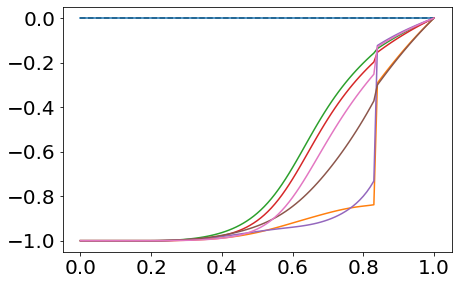

In [89]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv,msx[i])
#plt.xlabel("$s$")
#plt.ylabel("$\\langle \\sigma_z \\rangle$")
#plt.title("Qubit Z Magnetization")
plt.savefig("random-instance-magx-dqa-double.png", bbox_inches='tight')

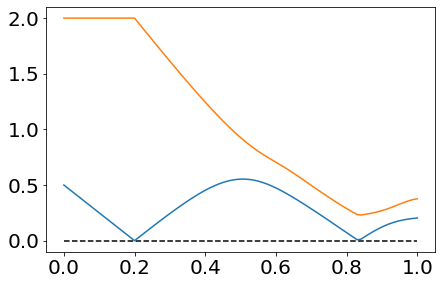

In [90]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))
plt.savefig("random-instance-spectrum-dqa-double.png", bbox_inches='tight')

In [91]:
msx_dqa = msx

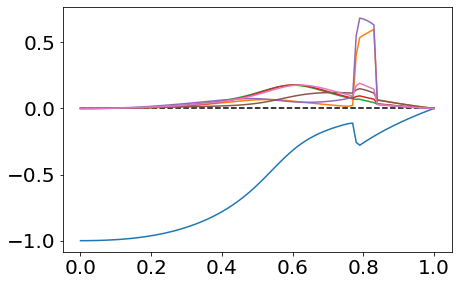

In [93]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv, msx_aqa[i] - msx_dqa[i])

In [51]:
init_dqa(1, 4)

In [52]:
npts = 101
n = 7
p = {'spause':0.2}
sv = np.linspace(0,1,npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s, p).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

# individual components of magnetization for each qubit
msz = np.zeros((n, npts))
msx = np.zeros((n, npts))
for j in range(n):
    sz = Hobj.getOperator(j, 'hz')
    sx = Hobj.getOperator(j, 'hx')
    for i,s in enumerate(sv):
        msz[j,i] = sz.overlap(V[i][0])
        msx[j,i] = sx.overlap(V[i][0])

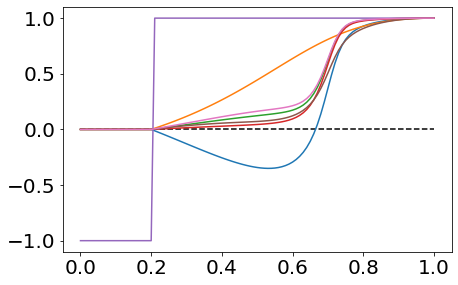

In [53]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv,msz[i])
#plt.xlabel("$s$")
#plt.ylabel("$\\langle \\sigma_z \\rangle$")
#plt.title("Qubit Z Magnetization")
#plt.savefig("random-instance-magz-dqa-double.png", bbox_inches='tight')

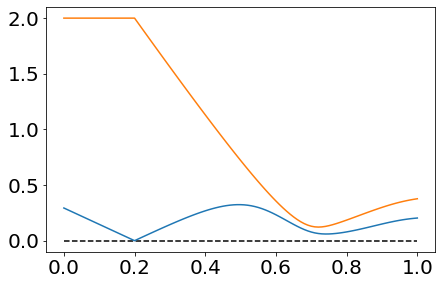

In [54]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))
#plt.savefig("random-instance-spectrum-dqa-double.png", bbox_inches='tight')

In [55]:
z_vals

array([ 1.        , -0.32610452,  0.16998698, -0.12109217, -0.58725647,
        0.19980255, -0.4370849 ])

### Instance where AQA wins massively

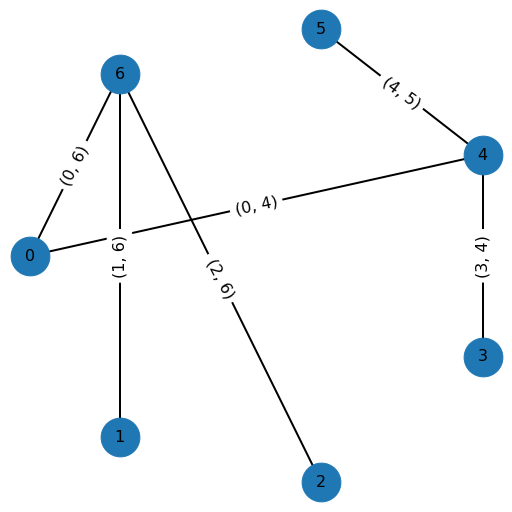

In [339]:
index = 56
count = 6
instances[count][index]
G = all_graphs[count][instances[count][index]['graph']]
z_vals = instances[count][index]['coefficients'][0]
J_vals = instances[count][index]['coefficients'][1]
Hobj = annealing.IsingGraph({1:G, 2:G})
Hobj.drawNthOrderGraph(1)

init_aqa(1)

In [340]:
npts = 101
n = 7
sv = np.linspace(0,1,npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

# individual components of magnetization for each qubit
msz = np.zeros((n, npts))
for j in range(n):
    sz = Hobj.getOperator(j, 'hz')
    for i,s in enumerate(sv):
        msz[j,i] = sz.overlap(V[i][0])


Text(0.5, 1.0, 'Qubit Z Magnetization')

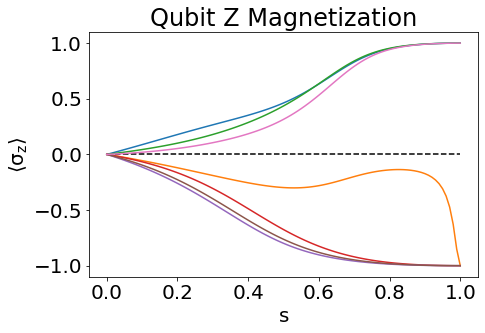

In [341]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv,msz[i])
plt.xlabel("$s$")
plt.ylabel("$\\langle \\sigma_z \\rangle$")
plt.title("Qubit Z Magnetization")

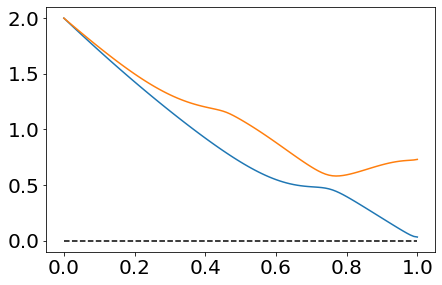

In [342]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))

In [343]:
dqa_probs = instance_data[count]["dqa_probs"]
dqa_probs[index]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [344]:
er_dqa_best = instance_data[count]["er_dqa_best"]
er_dqa_best[index]

0.207339763361162

In [345]:
aqa_probs[index]

0.5988781698879733

In [346]:
er_aqa = instance_data[count]["er_aqa"]
er_aqa[index]

0.08351634033738975

In [315]:
init_dqa(1, 2)

In [316]:
npts = 101
n = 7
p = {'spause':0.2}
sv = np.linspace(0,1,npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s, p).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

# individual components of magnetization for each qubit
msz = np.zeros((n, npts))
for j in range(n):
    sz = Hobj.getOperator(j, 'hz')
    for i,s in enumerate(sv):
        msz[j,i] = sz.overlap(V[i][0])


Text(0.5, 1.0, 'Qubit Z Magnetization')

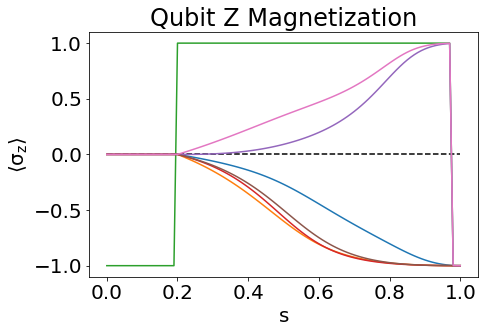

In [317]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv,msz[i])
plt.xlabel("$s$")
plt.ylabel("$\\langle \\sigma_z \\rangle$")
plt.title("Qubit Z Magnetization")

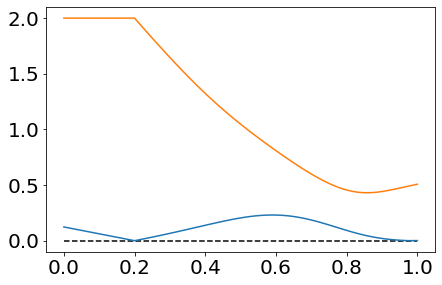

In [318]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))

### Instance where AQA and DQA are equal

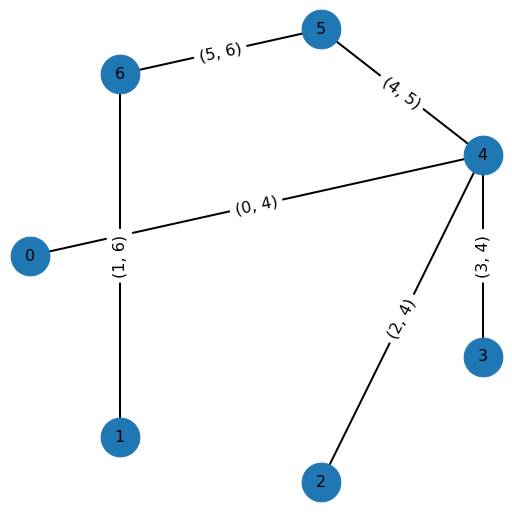

In [484]:
index = 231
count = 6
instances[count][index]
G = all_graphs[count][instances[count][index]['graph']]
z_vals = instances[count][index]['coefficients'][0]
J_vals = instances[count][index]['coefficients'][1]
Hobj = annealing.IsingGraph({1:G, 2:G})
Hobj.drawNthOrderGraph(1)

init_aqa(1)

In [485]:
npts = 101
n = 7
sv = np.linspace(0,1,npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

# individual components of magnetization for each qubit
msz = np.zeros((n, npts))
for j in range(n):
    sz = Hobj.getOperator(j, 'hz')
    for i,s in enumerate(sv):
        msz[j,i] = sz.overlap(V[i][0])


Text(0.5, 1.0, 'Qubit Z Magnetization')

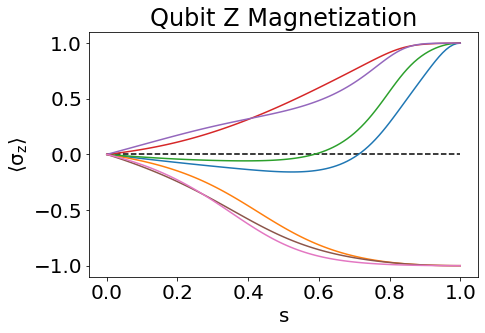

In [486]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv,msz[i])
plt.xlabel("$s$")
plt.ylabel("$\\langle \\sigma_z \\rangle$")
plt.title("Qubit Z Magnetization")

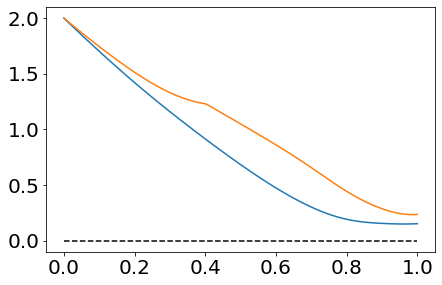

In [487]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))

In [488]:
dqa_probs = instance_data[count]["dqa_probs"]
dqa_probs[index]

[0.997036439340853, 0.0, 0.9316445385455588, 0.0, 0.0, 0.0, 0.0]

In [489]:
er_dqa_best = instance_data[count]["er_dqa_best"]
er_dqa_best[index]

0.010133178782322005

In [490]:
aqa_probs[index]

0.9332314880243071

In [491]:
er_aqa = instance_data[count]["er_aqa"]
er_aqa[index]

0.09101325296957086

In [492]:
init_dqa(1, 0)

In [493]:
npts = 101
n = 7
p = {'spause':0.2}
sv = np.linspace(0,1,npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s, p).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

# individual components of magnetization for each qubit
msz = np.zeros((n, npts))
for j in range(n):
    sz = Hobj.getOperator(j, 'hz')
    for i,s in enumerate(sv):
        msz[j,i] = sz.overlap(V[i][0])


Text(0.5, 1.0, 'Qubit Z Magnetization')

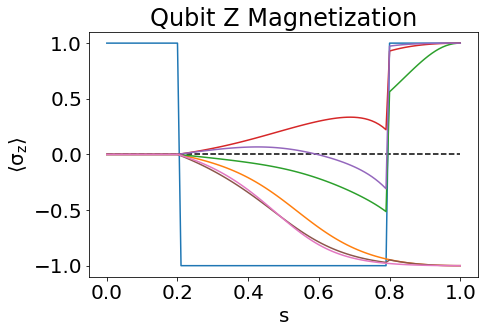

In [494]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv,msz[i])
plt.xlabel("$s$")
plt.ylabel("$\\langle \\sigma_z \\rangle$")
plt.title("Qubit Z Magnetization")

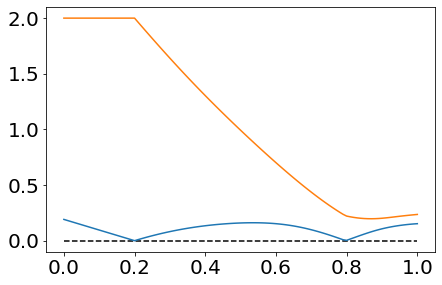

In [495]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))

([<matplotlib.patches.Wedge at 0x7f0e3fbcc3a0>,
 [Text(0.45581316233797436, 1.001116557169771, 'AQA Wins'),
  Text(-0.4558132560692696, -1.0011165144934584, 'DQA Wins'),
  Text(1.0999999999999808, -2.0597886570014373e-07, 'Tie')],
 [Text(0.24862536127525872, 0.5460635766380569, '36.4%'),
  Text(-0.24862541240141972, -0.5460635533600681, '63.6%'),
  Text(0.5999999999999894, -1.1235210856371475e-07, '0.0%')])

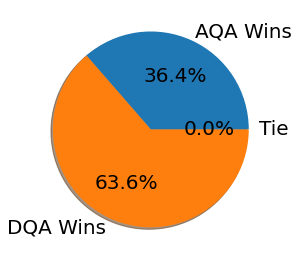

In [8]:
labels = ['AQA Wins', 'DQA Wins', 'Tie']
plt.pie([len(aqa_indices), len(dqa_indices), len(tied_indices)], labels=labels, shadow=True, autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7f0e3fb34250>,
 [Text(1.0461621663333946, 0.3399186987098808, 'Hard Instances'),
  Text(-1.0461621902025062, -0.33991862524830146, 'Easy Instances')],
 [Text(0.5706339089091244, 0.1854101992962986, '10.0%'),
  Text(-0.5706339219286397, -0.18541015922634624, '90.0%')])

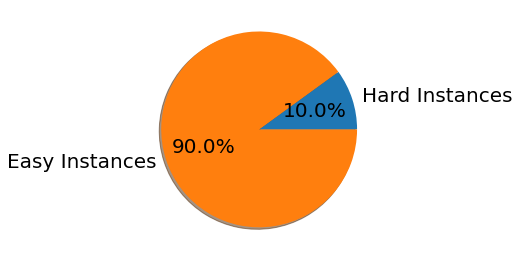

In [9]:
labels = ['Hard Instances', 'Easy Instances']
plt.pie([len(hard_instances), n_samples - len(hard_instances)], labels=labels, shadow=True, autopct='%1.1f%%')

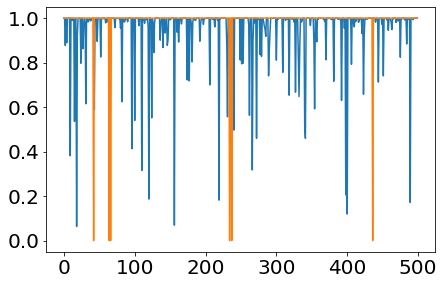

In [10]:
plt.plot(range(n_samples), aqa_probs)
plt.plot(range(n_samples), dqa_probs_best)

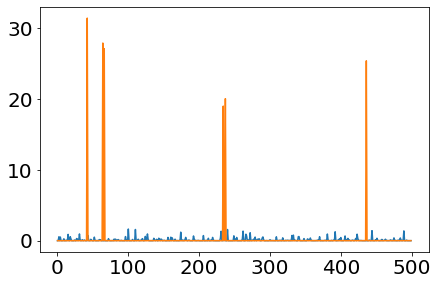

In [11]:
plt.plot(range(n_samples), er_aqa)
plt.plot(range(n_samples), er_dqa_best)

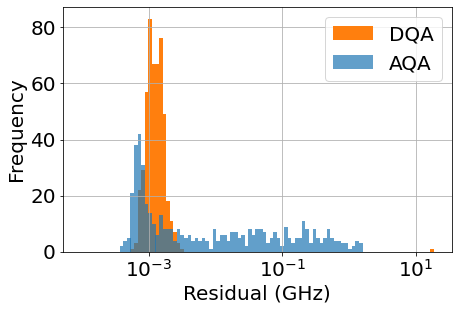

In [12]:
n_bins = 100
bins, a, a = plt.hist(
    np.array(er_dqa_best),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    facecolor='C1',
    rwidth=0.95,
    align='left',
    edgecolor='k',
    linewidth=0,
    label="DQA"
)
bins, a, a = plt.hist(
    np.array(er_aqa),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    facecolor='C0',
    rwidth=0.95,
    align='left',
    edgecolor='k',
    linewidth=0,
    label="AQA",
    alpha=0.7
)
plt.xlabel("Residual (GHz)")
plt.ylabel("Frequency")
plt.xscale('log')
plt.legend()
plt.grid()
#plt.xlabel("Qubits with Odd Flip Count")
#plt.ylabel("Frequency")

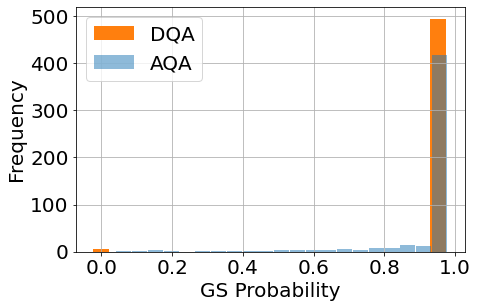

In [13]:
n_bins = 21
bins, a, a = plt.hist(
    np.array(dqa_probs_best),
    bins=n_bins,
    facecolor='C1',
    rwidth=0.95,
    align='left',
    edgecolor='k',
    linewidth=0,
    label="DQA",
)
bins, a, a = plt.hist(
    np.array(aqa_probs),
    bins=n_bins,
    facecolor='C0',
    rwidth=0.95,
    align='left',
    edgecolor='k',
    linewidth=0,
    label="AQA",
    alpha=0.5
)
plt.xlabel("GS Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

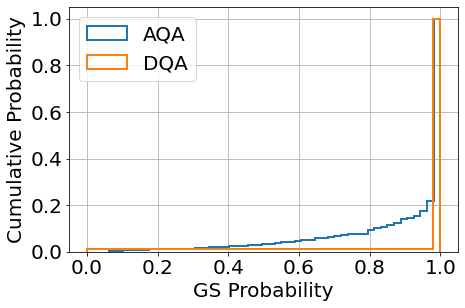

In [14]:
n_bins = 50
bins, a, a = plt.hist(
    np.array(aqa_probs),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="AQA",
    linewidth=2
)
bins, a, a = plt.hist(
    np.array(dqa_probs_best),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="DQA",
    linewidth=2
)
plt.xlabel("GS Probability")
plt.ylabel("Cumulative Probability")
#plt.xscale('log')
plt.legend(loc=2)
plt.grid()

### Hard Instances

In [15]:
hard_aqa_probs = []
hard_dqa_probs = []
hard_aqa_er = []
hard_dqa_er = []
aqa_wins = 0
for index in hard_instances:
    hard_aqa_probs.append(aqa_probs[index])
    hard_dqa_probs.append(dqa_probs_best[index])
    hard_aqa_er.append(er_aqa[index])
    hard_dqa_er.append(er_dqa_best[index])
    if er_aqa[index] < er_dqa_best[index]:
        aqa_wins += 1
dqa_wins = len(hard_instances) - aqa_wins

([<matplotlib.patches.Wedge at 0x7f0e3e487970>,
 [Text(1.1, 0.0, 'AQA Wins'), Text(-1.1, 1.3471114790620887e-16, 'DQA Wins')],
 [Text(0.6, 0.0, '0.0%'), Text(-0.6, 7.347880794884119e-17, '100.0%')])

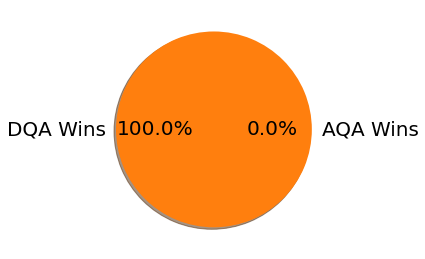

In [16]:
labels = ['AQA Wins', 'DQA Wins']
plt.pie([aqa_wins, dqa_wins], labels=labels, shadow=True, autopct='%1.1f%%')

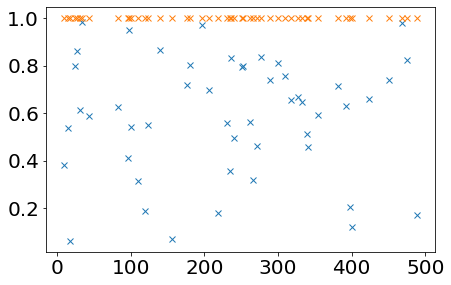

In [17]:
plt.plot(hard_instances, hard_aqa_probs, "C0x")
plt.plot(hard_instances, hard_dqa_probs, "C1x")
#plt.xlim(450, 480)

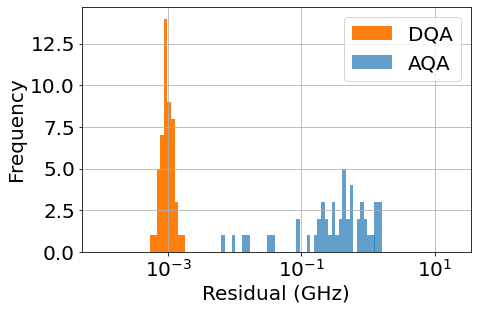

In [18]:
n_bins = 100
bins, a, a = plt.hist(
    np.array(hard_dqa_er),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    facecolor='C1',
    rwidth=0.95,
    align='left',
    edgecolor='k',
    linewidth=0,
    label="DQA"
)
bins, a, a = plt.hist(
    np.array(hard_aqa_er),
    bins=np.logspace(np.log10(1e-4), np.log10(2e1), n_bins),
    facecolor='C0',
    rwidth=0.95,
    align='left',
    edgecolor='k',
    linewidth=0,
    label="AQA",
    alpha=0.7
)
plt.xlabel("Residual (GHz)")
plt.ylabel("Frequency")
plt.xscale('log')
plt.legend()
plt.grid()
#plt.xlabel("Qubits with Odd Flip Count")
#plt.ylabel("Frequency")

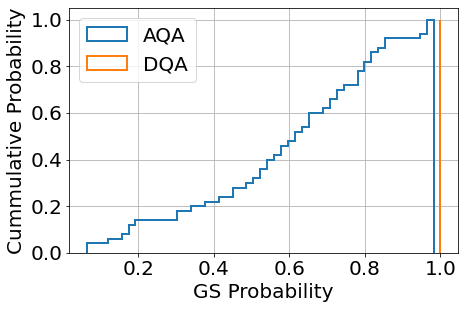

In [19]:
n_bins = 50
bins, a, a = plt.hist(
    np.array(hard_aqa_probs),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="AQA",
    linewidth=2
)
bins, a, a = plt.hist(
    np.array(hard_dqa_probs),
    bins=n_bins,
    density=True,
    histtype='step',
    cumulative=True,
    label="DQA",
    linewidth=2
)
plt.xlabel("GS Probability")
plt.ylabel("Cummulative Probability")
#plt.xscale('log')
plt.legend(loc=2)
plt.grid()

In [20]:
import pickle

def pickleWrite(obj, filename):
    # Open file for writing in binary
    fd = open(filename,"wb")
    
    # Pickle the object
    pickle.dump(obj,fd)
    
    # Write to file
    fd.close()
    
    return filename

def pickleRead(filename):
    # Read file in binary
    fd = open(filename,"rb")
    
    # Unpickle
    obj = pickle.load(fd)
    fd.close()
    
    return obj

In [21]:
obj = [
    aqa_probs,
    dqa_probs_best,
    dqa_probs,
    dqa_all,
    dqa_best_qubits,
    er_aqa,
    er_dqa,
    er_dqa_all,
    er_dqa_best,
    dqa_indices,
    dqa_wins,10
    aqa_indices,
    aqa_wins,
    tied_indices,
    tied,
    gap_values,
    hard_instances,
    hard_thresh,
    hard_aqa_probs,18
    hard_dqa_probs,
    hard_aqa_er,
    hard_dqa_er
]
pickleWrite(obj, "random-instances-dense.bin")

'random-instances-dense.bin'